# <center> RESPIRATORY RATE ESTIMATION
 
 **08/02/2023**   
    
 **Group 7:** **Giovanni Zago**, **Enrico Lupi**, **Emanuele Sarte**, **Alessio Saccomani** 
 
   The aim of this project is to estimate the Respiratory Rate (RR) by Seismocardiography(SCG), a technique where the detector is positioned above sternum, and Ballistocardiography (BCG), in which there is no contact between the sensor and the body: in this study the sensor was placed on the subject chest directly on a sweater). The measurements were taken using the detector MuSe (Multi-sensor miniaturized, low-power, wireless Inertial Measurement Unit), provided by 221e (https://www.221e.com). An IMU is a combination of an accelerometer and a gyroscope sensor, capable of detecting movements and measuring their intensity in terms of acceleration and rotational speeds. Sometimes, like in this case, a magnetometer is also included. 

<table><tr>
<td> 
  <p align="center" style="padding: 10px">
    <img alt="Forwarding" src="https://www.researchgate.net/profile/Niccolo-Mora/publication/332138445/figure/fig2/AS:743069842407425@1554173064707/Positioning-of-IMU-sensor-and-ECG-electrodes-The-IMU-is-placed-over-the-subjects.ppm" width="320">
    <br>
    <em style="color: grey"></em>
  </p> 
</td>
<td> 
  <p align="center">
    <img alt="Routing" src="https://www.221e.com/wp-content/uploads/2022/10/221e-Muse1.jpg" width="515">
    <br>
    <em style="color: grey"></em>
  </p> 
</td>
</tr></table>


# Load Data and First Steps

First, we import the necessary libraries for the analysis (pandas, numpy, matplotlib, scipy, ecc.). 

We then load the datafile 'center_sternum.txt' as a pandas dataframe. For the following analysis we decide to take into account the linear acceleration (in mg), the angular velocity (in degrees per second) and the magnetic field (in mG) in all three directions; the quaternions are not considered, instead, so they are dropped. Afterwards, we calibrate the measurements using the information in the file README_1.txt and we add to the dataset the absolute time at which every measurement is taken: as the data collection frequency is 200 Hz, each measurement is taken every 5 ms. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fftpack
from scipy import fft
from scipy import signal
from scipy import optimize
from scipy import linalg
import seaborn as sns
import pywt
sns.set_theme(style="ticks")

In [2]:
filenames = ["center_sternum.txt", "1_Stave_supine_static.txt", "2_Mattress_supine.txt", 
             "3_Subject_sitting_chair.txt", "4_Chest_sweater.txt", "5_Under_chair.txt"]
data_cuts = [(6,70), (16, 80), (14, 112), (5, 65), (5, 145), (8, 90)]

FILE_CHOSEN = 4

T1_CUT = data_cuts[FILE_CHOSEN][0]
T2_CUT = data_cuts[FILE_CHOSEN][1]
file_name = filenames[FILE_CHOSEN]

In [3]:
raw_data = pd.read_csv(file_name, sep="\t")

# We drop the columns we are not going to use
raw_data = raw_data.drop(["Log Mode", "qw", "qi", "qj", "qk"], axis=1)

# We look that the data collection frequency is the same for all the dataset
if len(raw_data["Log Freq"].unique()) != 1:
    print("There is more than one frequency")
    exit(1)

# We select the frequency
ACQ_FREQ = raw_data.loc[0, "Log Freq"]

# We create a column with the absolute time by multiplying 1/freq by integers
raw_data.insert(2, "Abs Time", np.arange(0, len(raw_data)) * (1 / ACQ_FREQ), allow_duplicates=False)

display(raw_data)


Log Freq   Timestamp  Abs Time     AccX     AccY     AccZ      GyroX  \
0           100  1555414552      0.00  687.836  380.823  580.354  -7.926829   
1           100  1555414552      0.01 -812.703 -108.946  726.876 -11.707320   
2           100  1555414552      0.02 -812.520 -108.824  733.952 -37.073170   
3           100  1555414552      0.03 -787.144  -45.628  616.954 -56.341460   
4           100  1555414552      0.04 -800.259 -137.433  411.689  -1.097561   
...         ...         ...       ...      ...      ...      ...        ...   
14933       100  1555415471    149.33 -890.722  -81.008  446.764  -2.682927   
14934       100  1555415471    149.34 -885.964  -76.006  459.025  -3.902439   
14935       100  1555415471    149.35 -879.681  -77.714  475.068  -3.048780   
14936       100  1555415471    149.36 -894.992  -76.311  502.701   0.121951   
14937       100  1555415471    149.37 -889.319  -90.951  471.835   3.536585   

            GyroY      GyroZ  MagnX  MagnY  MagnZ  
0        8.048780   0.975610   -592    122   -113  
1      -81.829270   8.780488    125     60   -128  
2     -145.487800  14.756100    123     59   -136  
3     -174.634200  23.048780    118     58   -145  
4       37.073170   1.341463    113     57   -157  
...           ...        ...    ...    ...    ...  
14933    2.926829   0.365854    144     47    -50  
14934    3.292683   0.365854    146     45    -51  
14935    2.804878   0.365854    144     46    -54  
14936    1.463415   0.609756    144     45    -53  
14937    0.853659   0.609756    144     45    -53  

[14938 rows x 12 columns]

In [4]:
#calibrate the dataset
offset_gyro = np.array([-2.242224, 2.963463, -0.718397])

calibration_acc = np.array([[1.000966,     -0.002326418,-0.0006995499],
                            [-0.002326379,  0.9787045,  -0.001540918],
                            [-0.0006995811,-0.001540928, 1.00403]])
offset_acc = np.array([-3.929942, -13.74679, 60.67546])

calibration_magn = np.array([[0.9192851, -0.02325168, 0.003480837],
                             [-0.02325175, 0.914876, 0.004257396],
                             [0.003481006, 0.004257583, 0.8748001]])
offset_magn = np.array([-95.67974, -244.9142, 17.71132])

if file_name != "center_sternum.txt":
    offset_gyro = np.array([-2.804399, 1.793105, 0.3411708])

    calibration_acc = np.array([[1.002982,    9.415505E-05, 0.004346743],
                                [9.04459E-05, 1.002731,    -0.001444198],
                                [0.004346536,-0.001444751,  1.030587]])
    offset_acc = np.array([3.602701, -20.96658, 54.97186])

    calibration_magn = np.array([[1.013437,    -0.04728858,  -0.001861475],
                                 [-0.04728862,  1.004832,    0.008222118],
                                 [-0.001861605, 0.008221965, 0.9439077]])
    offset_magn = np.array([-150.4098, 74.62431, 630.9805])

raw_data[['AccX', 'AccY', 'AccZ']] = np.dot(raw_data[['AccX', 'AccY', 'AccZ']], calibration_acc.T) + offset_acc.T
raw_data[['GyroX', 'GyroY', 'GyroZ']] = raw_data[['GyroX', 'GyroY', 'GyroZ']] + offset_gyro.T
raw_data[['MagnX', 'MagnY', 'MagnZ']] = np.dot(raw_data[['MagnX', 'MagnY', 'MagnZ']], calibration_magn.T) + offset_magn.T

display(raw_data)

Log Freq   Timestamp  Abs Time        AccX        AccY        AccZ  \
0           100  1555414552      0.00  696.048334  360.120513  655.516657   
1           100  1555414552      0.01 -808.374494 -131.333370  800.705773   
2           100  1555414552      0.02 -808.160179 -131.221239  807.998826   
3           100  1555414552      0.03 -783.211118  -67.681388  687.441203   
4           100  1555414552      0.04 -797.266105 -159.441850  475.973393   
...         ...         ...       ...         ...         ...         ...   
14933       100  1555415471    149.33 -887.841091 -102.921591  511.646512   
14934       100  1555415471    149.34 -883.015136  -97.923207  524.295993   
14935       100  1555415471    149.35 -876.643826  -99.658473  540.859477   
14936       100  1555415471    149.36 -891.880238  -98.292933  569.269111   
14937       100  1555415471    149.37 -886.325866 -112.927826  537.504822   

           GyroX       GyroY      GyroZ       MagnX       MagnY       MagnZ  
0     -10.731228    9.841885   1.316781 -755.923364  224.279578  526.424080  
1     -14.511719  -80.036165   9.121659  -26.329221  127.950721  510.420932  
2     -39.877569 -143.694695  15.097271  -28.293915  126.974690  502.865171  
3     -59.145859 -172.841095  23.389951  -33.297058  126.132302  494.371088  
4      -3.901960   38.866275   1.682634  -38.294616  125.265247  483.045282  
...          ...         ...        ...         ...         ...         ...  
14933  -5.487326    4.719934   0.707024   -6.604362  114.630747  583.903476  
14934  -6.706838    5.085788   0.707024   -4.481049  112.518283  582.939401  
14935  -5.853179    4.597983   0.707024   -6.549627  113.593026  580.119623  
14936  -2.682448    3.256520   0.950927   -6.504200  112.596416  581.055309  
14937   0.732186    2.646764   0.950927   -6.504200  112.596416  581.055309  

[14938 rows x 12 columns]

# Data Visualization

We now plot the accelerations, the angular velocity and the magnetic field components as a function of time in order to look at their general trend and to select a proper time window to conduct the analysis in. This is necessary as signals are very disturbed at the beginning and end of the data taking, probably due to sudden movements of the test subject: they are ususally used to coordinate the data taking across various devices, but they mud the data and need of course to be eliminated. 

From 6 to 70 seconds all features have a regular behaviour and thus we select this to be the time window to be used in the rest of the project. In the plots this time window is highlighted.

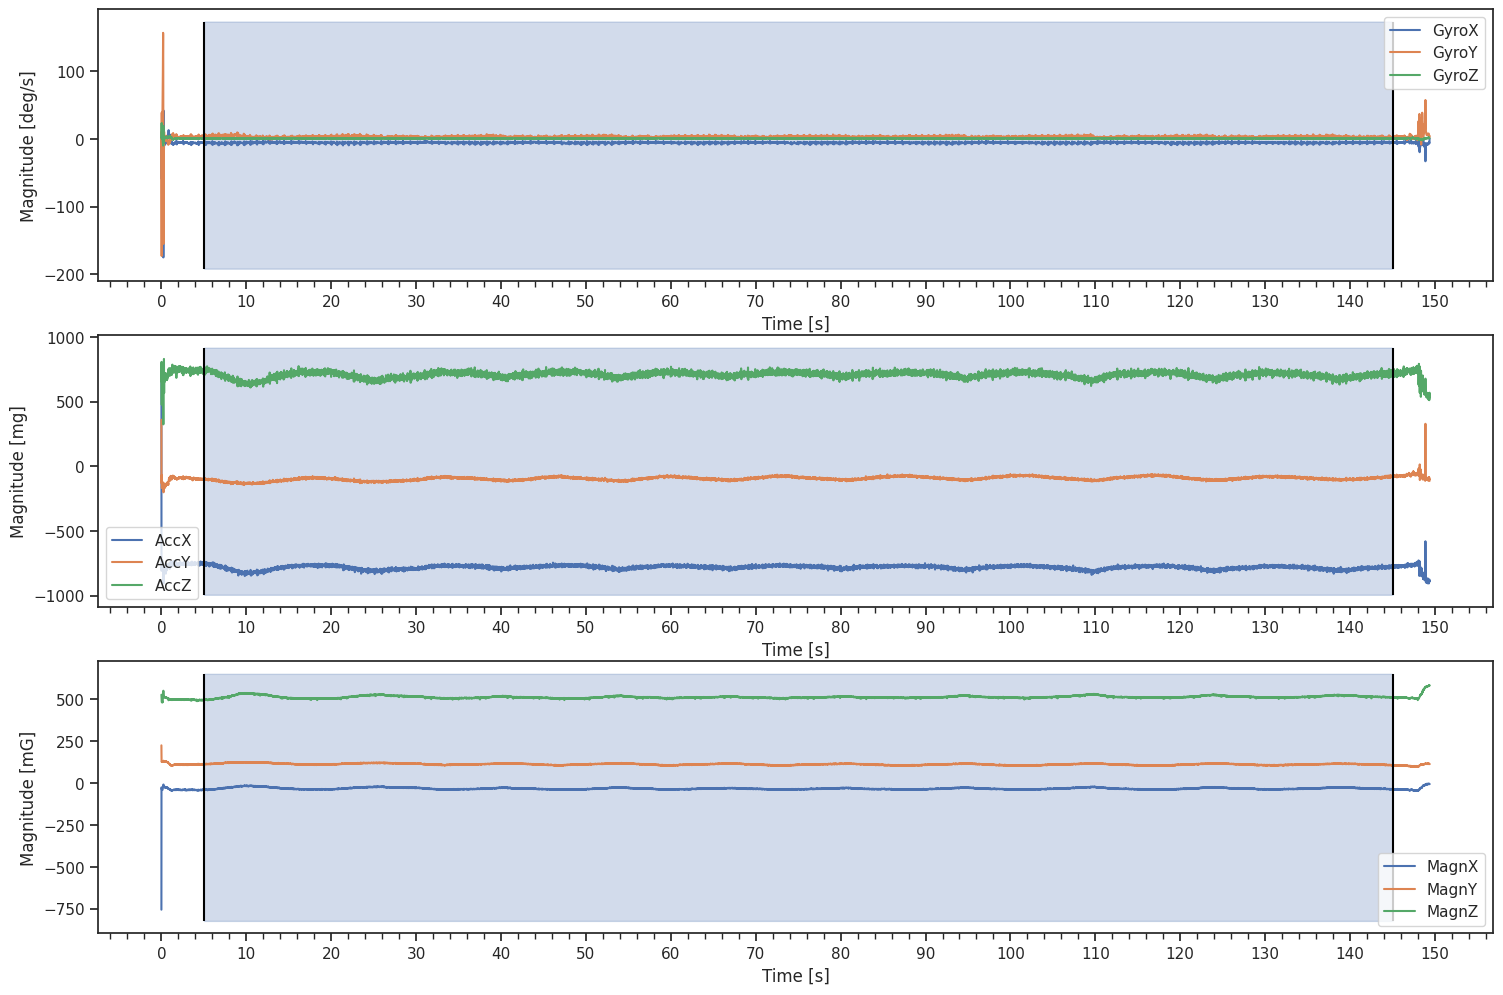

Log Freq   Timestamp  Abs Time        AccX        AccY        AccZ  \
500         100  1555415329      5.00 -757.202112  -98.163345  747.884936   
501         100  1555415329      5.01 -751.950357 -104.643446  745.716777   
502         100  1555415329      5.02 -759.882114  -96.679198  736.178380   
503         100  1555415329      5.03 -762.978256  -96.626330  741.885558   
504         100  1555415329      5.04 -744.331929 -101.839769  709.724376   
...         ...         ...       ...         ...         ...         ...   
14496       100  1555415467    144.96 -781.961363  -73.419291  722.784755   
14497       100  1555415467    144.97 -782.066864  -76.646502  712.353437   
14498       100  1555415467    144.98 -764.988723  -75.567051  728.896401   
14499       100  1555415467    144.99 -775.920147  -77.817630  719.171133   
14500       100  1555415467    145.00 -777.468677  -77.403615  729.159286   

          GyroX     GyroY     GyroZ      MagnX       MagnY       MagnZ  
500   -5.853179  3.500422  0.707024 -39.541784  108.384568  495.180032  
501   -5.975131  3.622373  0.707024 -40.793525  113.464239  496.166911  
502   -5.731228  3.622373  0.707024 -41.759674  112.506696  496.160550  
503   -6.097082  4.597983  0.463122 -40.744375  112.451185  495.214781  
504   -6.097082  4.476032  0.341171 -41.712385  111.501864  496.152328  
...         ...       ...       ...        ...         ...         ...  
14496 -5.609277  2.890666  0.828976 -37.455701  106.436547  513.094111  
14497 -5.365375  3.256520  0.707024 -36.482106  107.361202  509.324840  
14498 -5.365375  2.524812  0.707024 -36.389391  105.359760  510.252304  
14499 -5.365375  2.280910  0.463122 -38.419988  105.470782  512.143843  
14500 -5.243423  2.524812  0.828976 -37.355539  104.402217  510.245944  

[14001 rows x 12 columns]

In [5]:
from matplotlib.ticker import AutoMinorLocator, MultipleLocator, FuncFormatter

labels = ["GyroX", "GyroY", "GyroZ", "AccX", "AccY", "AccZ", "MagnX", "MagnY", "MagnZ"]
unit = ["[deg/s]", "[mg]", "[mG]"]
Nvar = len(labels)
   
IT1_CUT = round(T1_CUT * ACQ_FREQ)
IT2_CUT = round(T2_CUT * ACQ_FREQ) + 1

plt.figure(figsize=(18, 4 * (Nvar // 3)))
for i in range(Nvar // 3):
    ax = plt.subplot(Nvar // 3, 1, i + 1)
    plt.plot(raw_data["Abs Time"], raw_data[labels[i * 3]],     label=labels[i * 3])
    plt.plot(raw_data["Abs Time"], raw_data[labels[i * 3 + 1]], label=labels[i * 3 + 1])
    plt.plot(raw_data["Abs Time"], raw_data[labels[i * 3 + 2]], label=labels[i * 3 + 2])
    ymin, ymax = plt.ylim()
    plt.vlines(x=raw_data.loc[IT1_CUT, "Abs Time"], ymin=ymin, ymax=ymax, colors="black")
    plt.vlines(x=raw_data.loc[IT2_CUT, "Abs Time"], ymin=ymin, ymax=ymax, colors="black")

    ax.fill_between(raw_data.loc[IT1_CUT: IT2_CUT, "Abs Time"], ymin, ymax, color='C0', alpha=0.25)

    ax.xaxis.set_major_locator(MultipleLocator(10))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    plt.xlabel("Time [s]")
    plt.ylabel("Magnitude "+unit[i])
    plt.legend()

plt.show()

raw_data_cut = raw_data.loc[IT1_CUT: IT2_CUT - 1, :]
display(raw_data_cut)

# Statistical Analysis

We calculate the mean, standard deviation, minimum, 25th, 50th, 75th percentiles and maximum for all features (in the selected time window); data is then normalized. 
For the accelerations and the angular velocities the 25th and 75th percentiles are nearly symmetric, so the variables change quite regularly. 

Afterwards, normalized data is plotted in a 9x9 grid in order to highlight possible correlations: however, no significant correlation has been noticed. 

In [6]:
raw_data_cut.drop(["Log Freq", "Timestamp", "Abs Time"], axis=1).describe()

AccX          AccY          AccZ         GyroX         GyroY  \
count  14001.000000  14001.000000  14001.000000  14001.000000  14001.000000   
mean    -782.951416    -95.376275    707.404467     -5.625426      3.331096   
std       14.571388     13.971037     22.822639      0.808460      1.001780   
min     -849.150379   -145.278184    609.693162     -9.633667     -1.133724   
25%     -791.906267   -104.534624    694.020837     -5.975131      2.646764   
50%     -780.480737    -94.905164    710.516646     -5.609277      3.256520   
75%     -772.316491    -84.898940    723.382941     -5.121472      3.866276   
max     -740.557246    -61.608498    774.745622     -2.438545      9.597983   

              GyroZ         MagnX         MagnY         MagnZ  
count  14001.000000  14001.000000  14001.000000  14001.000000  
mean       0.622152    -33.442610    111.297327    512.591771  
std        0.238909      4.670379      4.449150      6.530829  
min       -0.390536    -43.830113    101.371277    493.335188  
25%        0.463122    -36.671261    108.302301    508.370074  
50%        0.585073    -34.606405    111.294175    511.250042  
75%        0.828976    -30.696385    114.131827    515.974080  
max        1.438732    -15.959518    124.895069    536.810789

In [7]:
data_std = (raw_data_cut[labels] - np.mean(raw_data_cut[labels], axis=0)) / np.std(raw_data_cut[labels], axis=0)
data_std.insert(0, "Abs Time", raw_data_cut["Abs Time"])
data_std.set_index(np.arange(0, len(data_std)), inplace=True)
display(data_std)

Abs Time     GyroX     GyroY     GyroZ      AccX      AccY      AccZ  \
0          5.00 -0.281722  0.169031  0.355260  1.767177 -0.199496  1.773761   
1          5.01 -0.432573  0.290770  0.355260  2.127606 -0.663337  1.678758   
2          5.02 -0.130874  0.290770  0.355260  1.583248 -0.093262  1.260807   
3          5.03 -0.583422  1.264681 -0.665676  1.370760 -0.089478  1.510882   
4          5.04 -0.583422  1.142942 -1.176143  2.650459 -0.462652  0.101653   
...         ...       ...       ...       ...       ...       ...       ...   
13996    144.96  0.019975 -0.439663  0.865728  0.067947  1.571663  0.673929   
13997    144.97  0.321673 -0.074446  0.355260  0.060707  1.340662  0.216853   
13998    144.98  0.321673 -0.804880  0.355260  1.232781  1.417928  0.941727   
13999    144.99  0.321673 -1.048358 -0.665676  0.482557  1.256834  0.515588   
14000    145.00  0.472523 -0.804880  0.865728  0.376281  1.286469  0.953246   

          MagnX     MagnY     MagnZ  
0     -1.305974 -0.654701 -2.666179  
1     -1.574000  0.487057 -2.515063  
2     -1.780875  0.271830 -2.516037  
3     -1.563476  0.259353 -2.660858  
4     -1.770749  0.045974 -2.517296  
...         ...       ...       ...  
13996 -0.859295 -1.092558  0.076921  
13997 -0.650826 -0.884723 -0.500250  
13998 -0.630974 -1.334587 -0.358232  
13999 -1.065771 -1.309633 -0.068589  
14000 -0.837848 -1.549814 -0.359206  

[14001 rows x 10 columns]

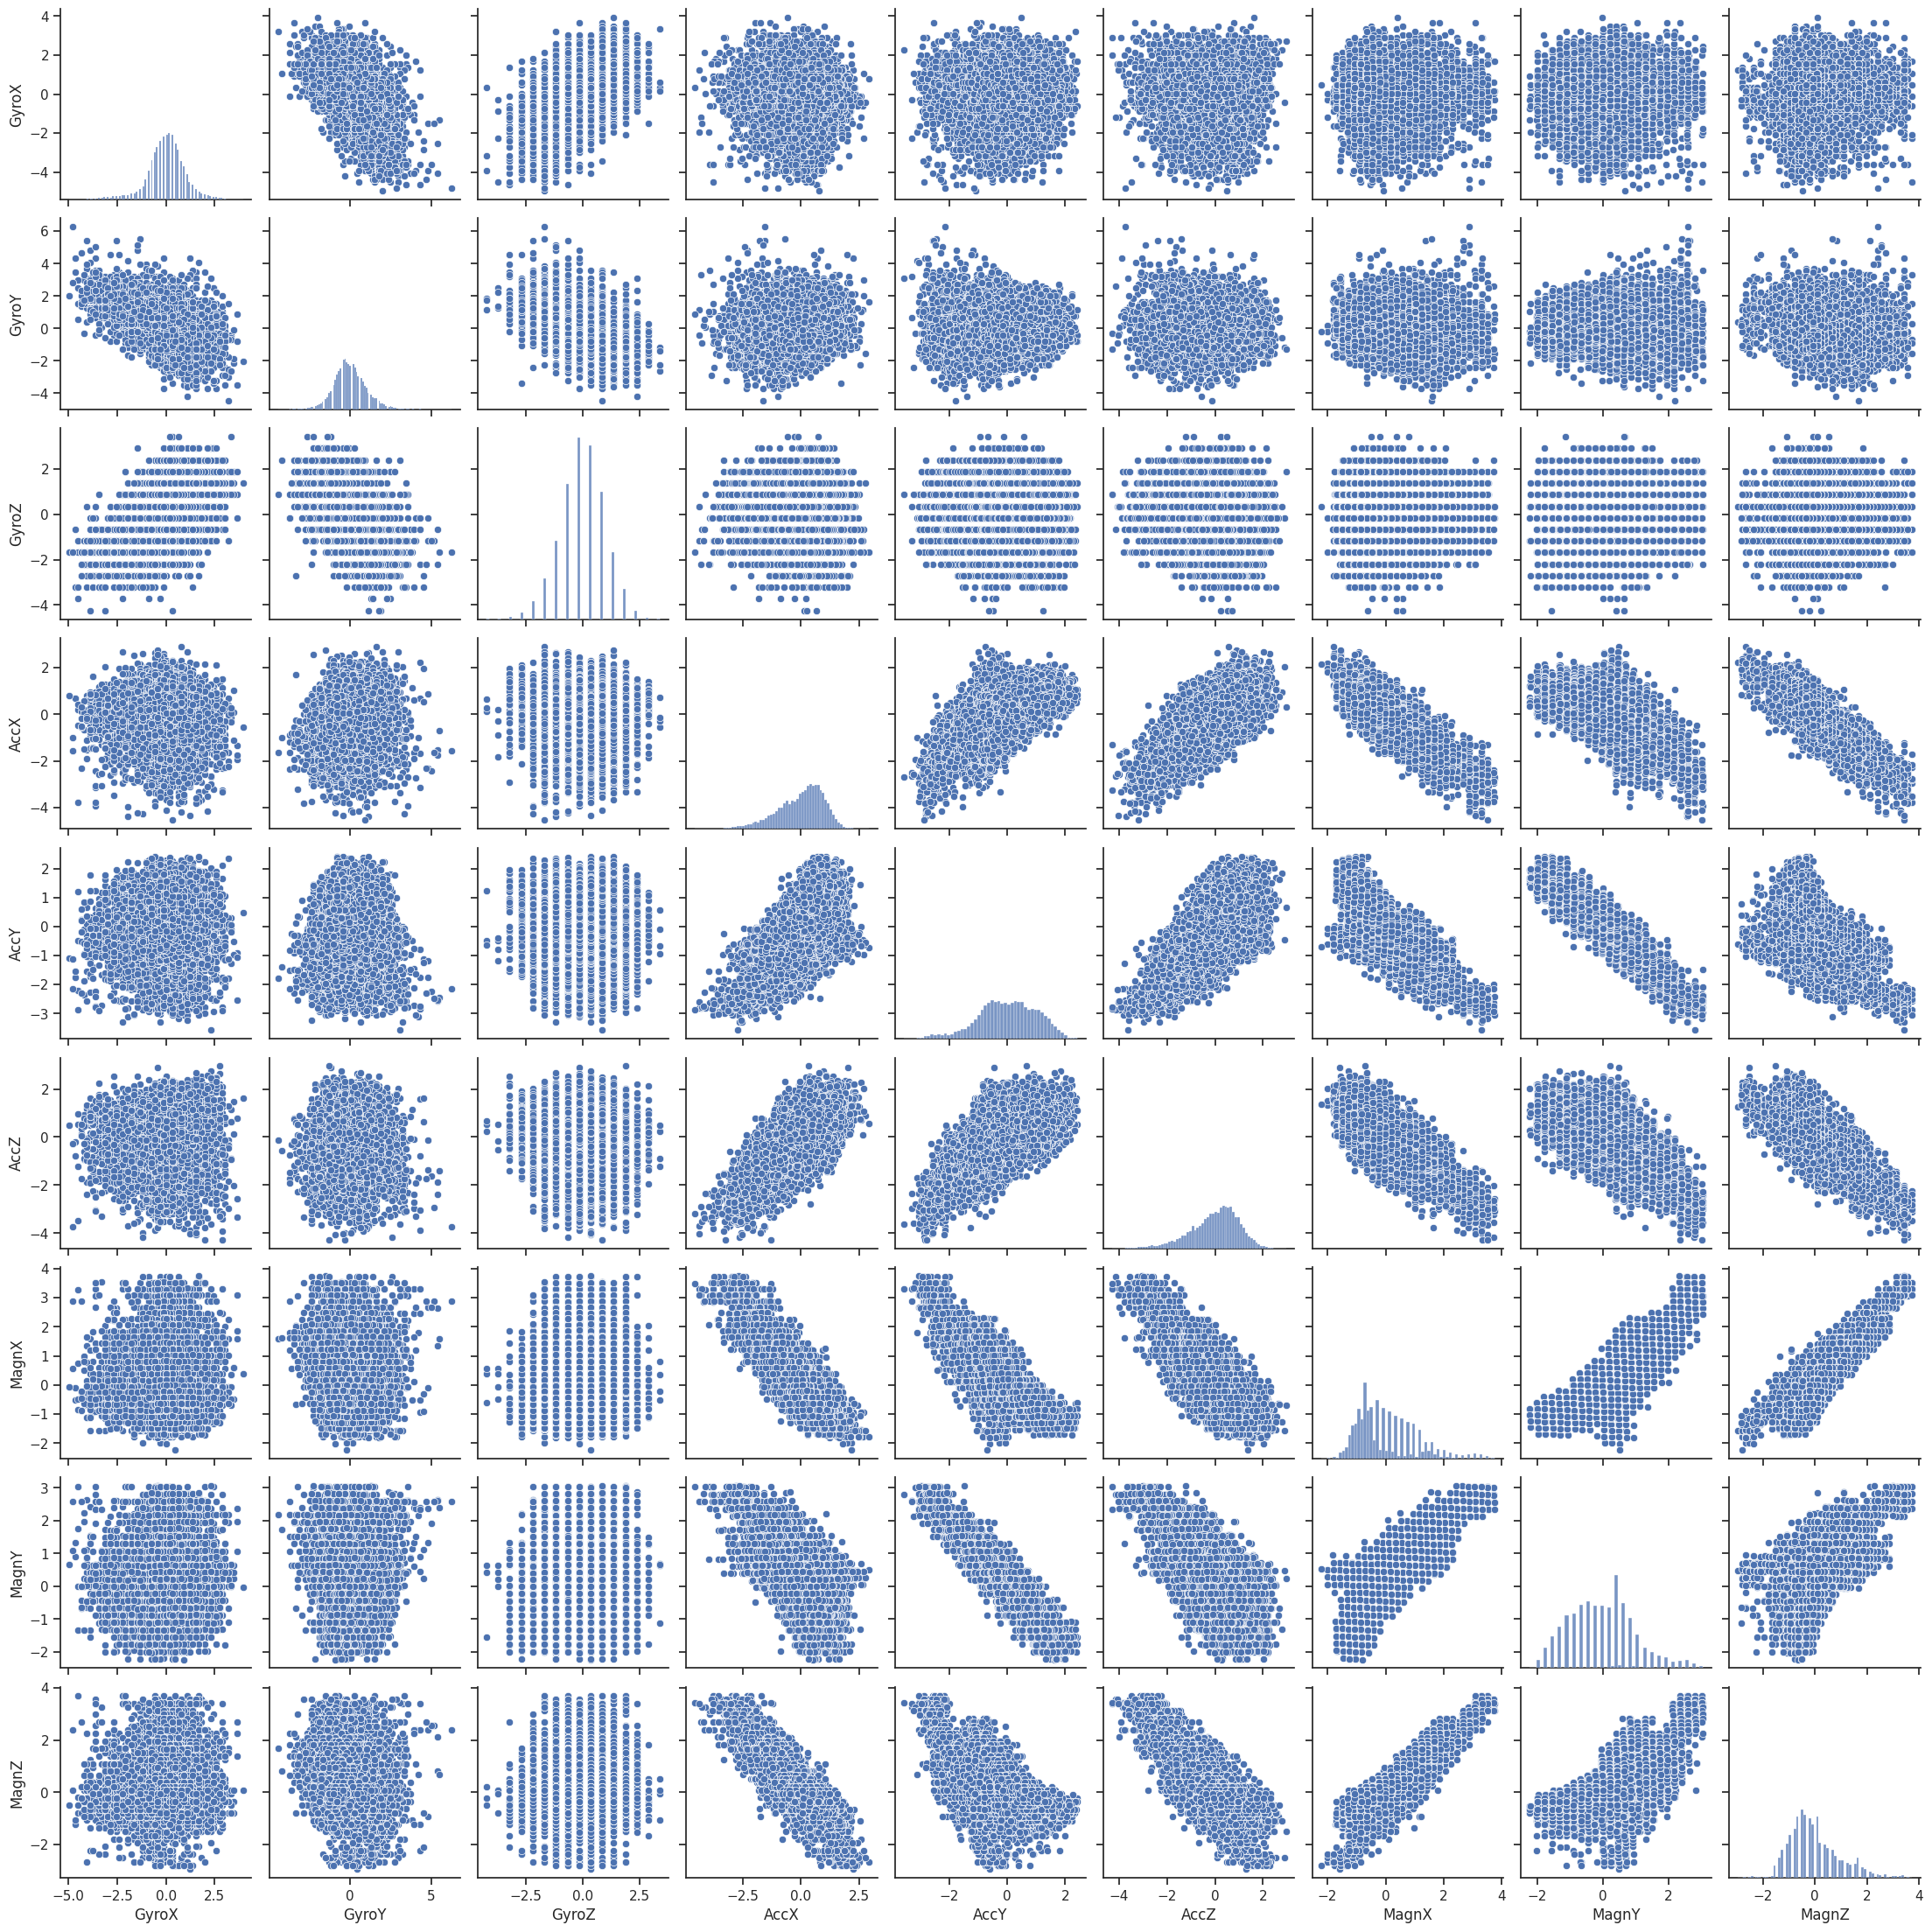

In [8]:
sns.pairplot(data_std[labels]);

# PCA

In order to reduce the dimensionality of the dataset we perform a **PCA**, keeping only 6 out of the total 9 principal components so as to maintain at least 85% of the total variability.

In [9]:
avls, avts = linalg.eig(np.cov(data_std[labels].T))
sort_perm = np.flip(np.argsort(avls))

avls = np.real_if_close(avls[sort_perm])
avts = avts[:, sort_perm]

var_ratios = avls / np.sum(avls)
print('Eigenvalues (sorted):\n', np.round(avls, 4)) 
print('Variability ratios:\n', np.round(var_ratios * 100, 2))
print("Eigenvector:")
display(pd.DataFrame(avts, columns=[f"Avt {i+1}" for i in range(len(avls))]))

Eigenvalues (sorted):
 [4.937  2.0296 0.5708 0.5114 0.4476 0.2651 0.1444 0.0541 0.0407]
Variability ratios:
 [54.85 22.55  6.34  5.68  4.97  2.95  1.6   0.6   0.45]
Eigenvector:


Avt 1     Avt 2     Avt 3     Avt 4     Avt 5     Avt 6     Avt 7  \
0  0.013613  0.569485 -0.007607 -0.782300  0.248899  0.015825 -0.021255   
1  0.004204 -0.587428  0.286834 -0.201303  0.706079  0.181059 -0.027992   
2  0.012146  0.573064  0.368948  0.558373  0.447016  0.153072  0.007167   
3 -0.403640 -0.008573  0.335739 -0.020416 -0.054090 -0.469689 -0.699313   
4 -0.401083  0.036194 -0.500430  0.081801  0.246424  0.022429 -0.152538   
5 -0.392649  0.003214  0.136243 -0.072384 -0.291034  0.824146 -0.223079   
6  0.437855  0.003295 -0.054655  0.013146 -0.019652  0.119933 -0.385424   
7  0.406064 -0.021721  0.453681 -0.113552 -0.257183  0.055247 -0.122171   
8  0.406299  0.018343 -0.437058  0.101438  0.157474  0.160541 -0.522652   

      Avt 8     Avt 9  
0 -0.027035  0.008204  
1  0.000976  0.000113  
2  0.015520 -0.000905  
3 -0.098767  0.039206  
4  0.669724 -0.218347  
5 -0.087361  0.026504  
6 -0.123057 -0.791610  
7  0.712634  0.154760  
8 -0.100596  0.547192

In [10]:
PCA_LABELS = [f"PC{i+1}" for i in range(len(avls))]
data_rot = pd.DataFrame(data=np.dot(avts.T, data_std[labels].T).T, columns=PCA_LABELS)

perc_thr = .85
N_PCA = np.argmax(np.cumsum(var_ratios) >= perc_thr) + 1

print(f'To keep {int(perc_thr * 100)}% of variability in our dataset we need {N_PCA} out of the {len(var_ratios)} principal components')

display(data_rot)

PCA_LABELS = PCA_LABELS[:N_PCA]
data_pca = data_rot[data_rot.columns[:N_PCA]]
data_pca.insert(0, "Abs Time", data_std["Abs Time"])
display(data_pca)



To keep 85% of variability in our dataset we need 4 out of the 9 principal components


PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0     -3.249507 -0.111800  2.056134 -0.009335 -0.678745  0.087036  0.379561   
1     -2.765522 -0.312316  2.898982 -0.072099 -1.001059 -0.096105  0.104087   
2     -2.784603 -0.112570  2.285788 -0.198498 -0.575140 -0.204176  0.591166   
3     -2.781728 -1.526361  2.198498 -0.634453 -0.540718  0.116843  0.651863   
4     -2.721044 -1.769800  2.251415 -0.813557 -0.524348 -1.767778  0.158918   
...         ...       ...       ...       ...       ...       ...       ...   
13996 -1.702114  0.846544 -0.961057  0.755241  0.579000  0.460913  0.004963   
13997 -1.486459  0.487104 -0.660882  0.095602  0.611832  0.019022  0.322852   
13998 -2.394516  0.923702 -0.684040  0.238313 -0.021560 -0.064278 -0.676756   
13999 -1.935747  0.484235 -1.451378 -0.228922 -0.477209 -0.271348 -0.019831   
14000 -2.170714  1.308737 -0.802969  0.432854  0.314019  0.388223  0.046679   

            PC8       PC9  
0     -0.487454 -0.369169  
1      0.010236  0.214059  
2      0.346327  0.189563  
3      0.324266 -0.068915  
4     -0.077975  0.235449  
...         ...       ...  
13996  0.318871  0.229922  
13997  0.369605 -0.177745  
13998 -0.095767 -0.137159  
13999 -0.066261  0.364747  
14000 -0.224200 -0.011031  

[14001 rows x 9 columns]

Abs Time       PC1       PC2       PC3       PC4
0          5.00 -3.249507 -0.111800  2.056134 -0.009335
1          5.01 -2.765522 -0.312316  2.898982 -0.072099
2          5.02 -2.784603 -0.112570  2.285788 -0.198498
3          5.03 -2.781728 -1.526361  2.198498 -0.634453
4          5.04 -2.721044 -1.769800  2.251415 -0.813557
...         ...       ...       ...       ...       ...
13996    144.96 -1.702114  0.846544 -0.961057  0.755241
13997    144.97 -1.486459  0.487104 -0.660882  0.095602
13998    144.98 -2.394516  0.923702 -0.684040  0.238313
13999    144.99 -1.935747  0.484235 -1.451378 -0.228922
14000    145.00 -2.170714  1.308737 -0.802969  0.432854

[14001 rows x 5 columns]

# Fourier Analysis

We then perform a **Fourier analysis** using the scipy fft library in order to extrapolate the principal frequencies of the data: we expect to see a peak in the range [0.1, 0.3] Hz, the average respiratory rate in an adult.

We first plot as an example the whole power spectrum of PC3: we can clearly see a **peak around 0.2 Hz** due to respiration and one around 1.1 Hz corresponding to the heart rate, while the peaks at high frequencies are due to noise. As we are only interested in the respiratory rate, all following plots will be focused only in the [0, 0.9] Hz range.

In [11]:
sig_fft = fft.fftshift(fft.fft(data_pca[PCA_LABELS], axis=0))
sample_freq = fft.fftshift(fft.fftfreq(len(data_pca), d=1/ACQ_FREQ))

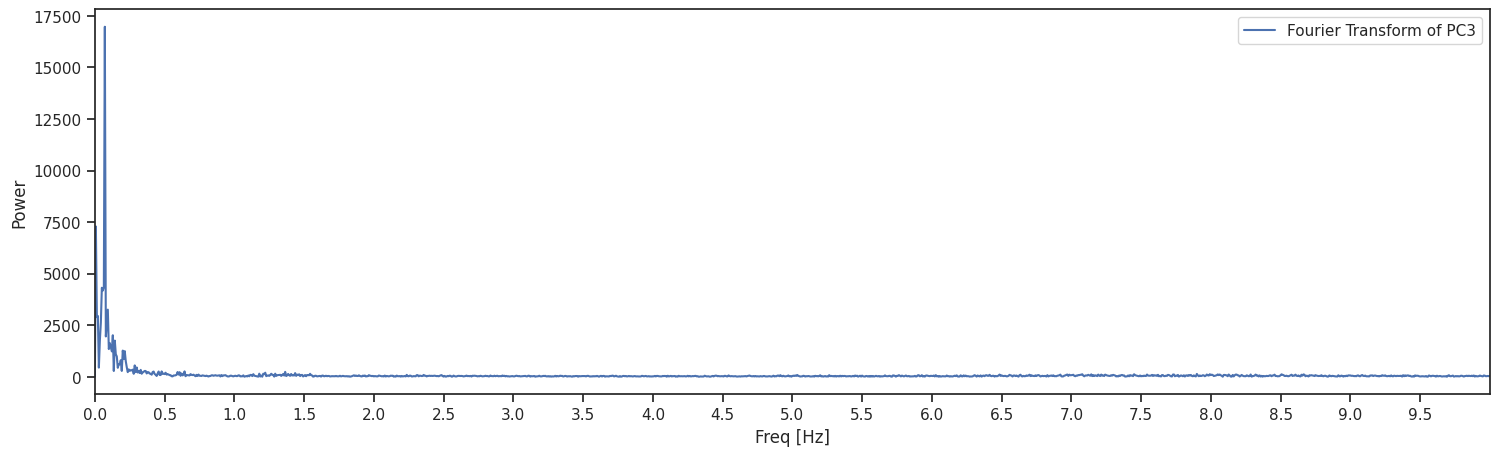

In [12]:
plt.figure(figsize=(18, 5))
ax = plt.subplot(1, 1, 1)
ax.plot(sample_freq, np.abs(sig_fft[:, 2]), label="Fourier Transform of " + PCA_LABELS[2])
ax.set_xlim(0, 10)
ax.set_xticks(np.arange(0, 10, 0.5))
plt.xlabel("Freq [Hz]")
plt.ylabel("Power")
plt.legend(loc="best");

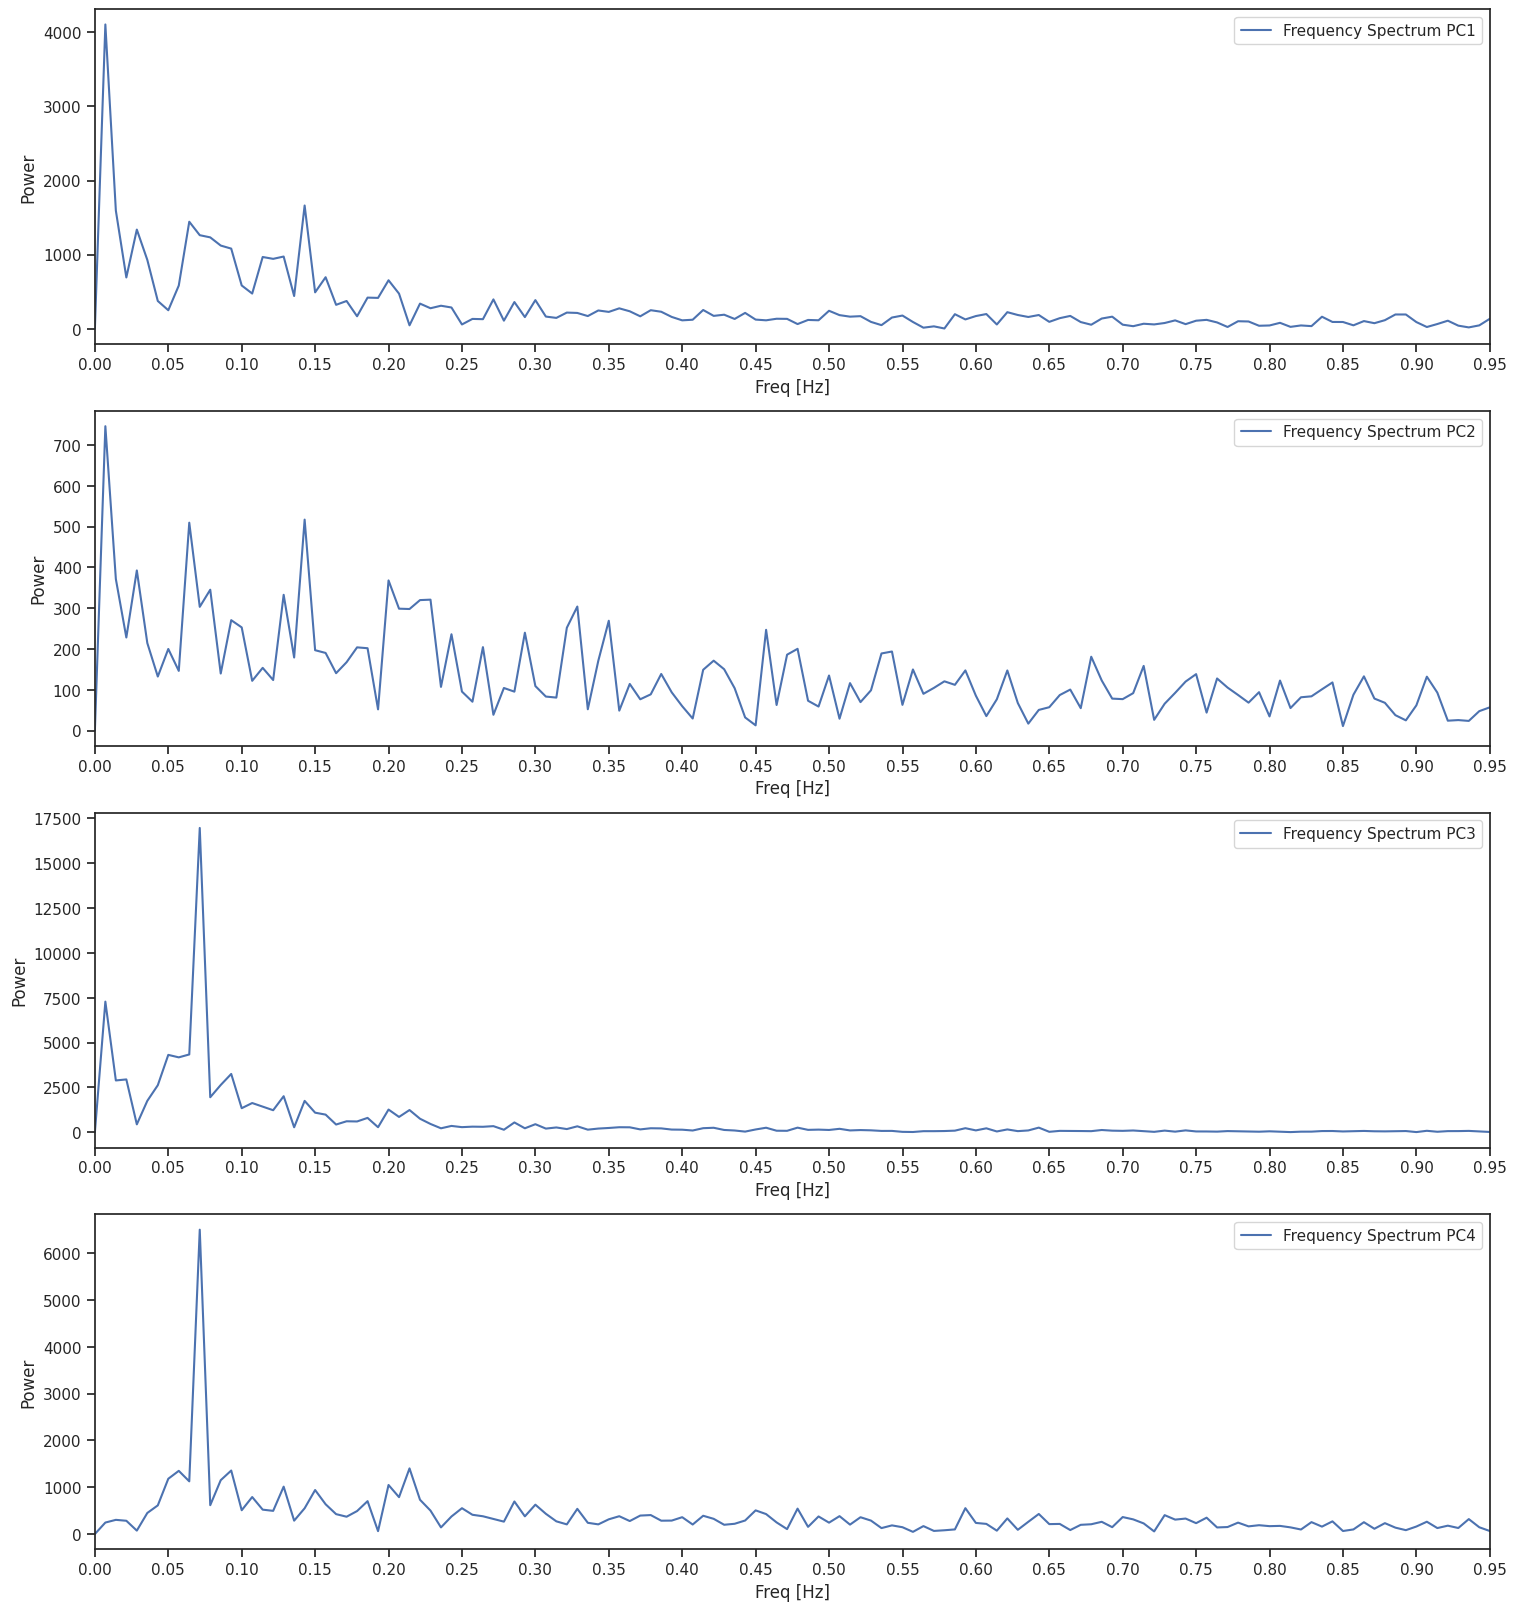

In [13]:
plt.figure(figsize=(18, 5 * N_PCA))
for i in range(N_PCA):
    ax = plt.subplot(N_PCA, 1, i+1)
    plt.plot(sample_freq, np.abs(sig_fft[:, i]), label="Frequency Spectrum " + PCA_LABELS[i])
    ax.set_xlim(0, 0.9)
    plt.xticks(np.arange(0, 1, 0.05))
        
    plt.xlabel("Freq [Hz]")
    plt.ylabel("Power")
    plt.legend(loc="best")
    

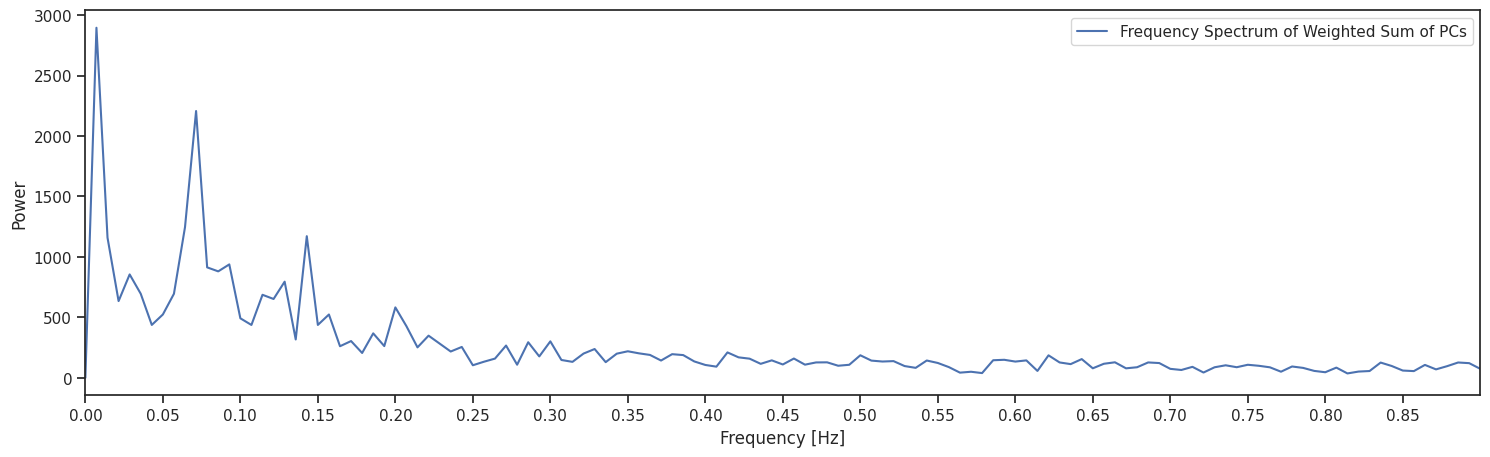

In [14]:
sig_fft_w = np.zeros_like(sig_fft)
for i in range(N_PCA):
    sig_fft_w[:, i] = sig_fft[:, i]*var_ratios[i] 
total_FFT = np.sum(np.abs(sig_fft_w), axis=1)
plt.figure(figsize=(18, 5))
plt.plot(sample_freq, total_FFT, label="Frequency Spectrum of Weighted Sum of PCs")
plt.xlabel("Frequency [Hz]")
plt.ylabel("Power")
plt.xticks(np.arange(0, 0.9, 0.05))
plt.xlim(left=0, right=0.9)
plt.legend();

# Filter

We now apply a filter using a **wavelet transform** in order to extrapolate only the components of the signal at the desired frequencies.

Wavelet transform is a powerful alternative to Fourier transform, able not only to the frequency information of the dataset but also at which moment a particular frequency is present. In this project we used a dyadic tree-level wavelet decomposition via the wavelet **sym5**, as it is smooth and allows for a high level of decomposition. In the first level, the signal is split into low- and high-frequency components, that respectively provide the coarser part and the detailed information of the original signal and are thus termed as the approximation and the detail; this first low-frequency subband component is then downsampled by a factor of 2 and again decomposed into low- and high-frequency subbands. This process can be repeated to J levels as desired: in this project we stopped at level 10. The frequency range covered by AJ is $0$ to $f_{s}/2^{J+1}$ Hz and that for Dj is $f_{s}/2^{j+1}$ to $f_{s}/2^{j}$ Hz ($1\le j \le J$), where $f_{s}$ represents the sampling frequency (in unit Hz) of the original signal, so 200 Hz in our case. [Source](https://doi.org/10.1016/j.bspc.2019.101779) 

For this project we want to filter the high frquencies components due to heart beats and noise, and also very low, near-zero frequencies: we will thus reconstruct the time signal using only the coefficients for **D10** and **D9** which correspond to a range of [0.098, 0.39] Hz.

In [15]:
#Filter signal using wavelets

lvl = 10
if file_name != "center_sternum.txt":
    lvl = 9

coeffs = pywt.wavedec(data_pca[PCA_LABELS], "sym5", level=lvl, axis=0)
#set coefficients related to undesired freuqncies to zero 
coeffs[0] = np.zeros_like(coeffs[0]) #set A10 to zero
for i in range(3, lvl + 1):
    coeffs[i] = np.zeros_like(coeffs[i]) #set Dj to zero with j from 8 to 1

#reconstruct time signal 
filtered_sig = pywt.waverec(coeffs, "sym5", axis=0)

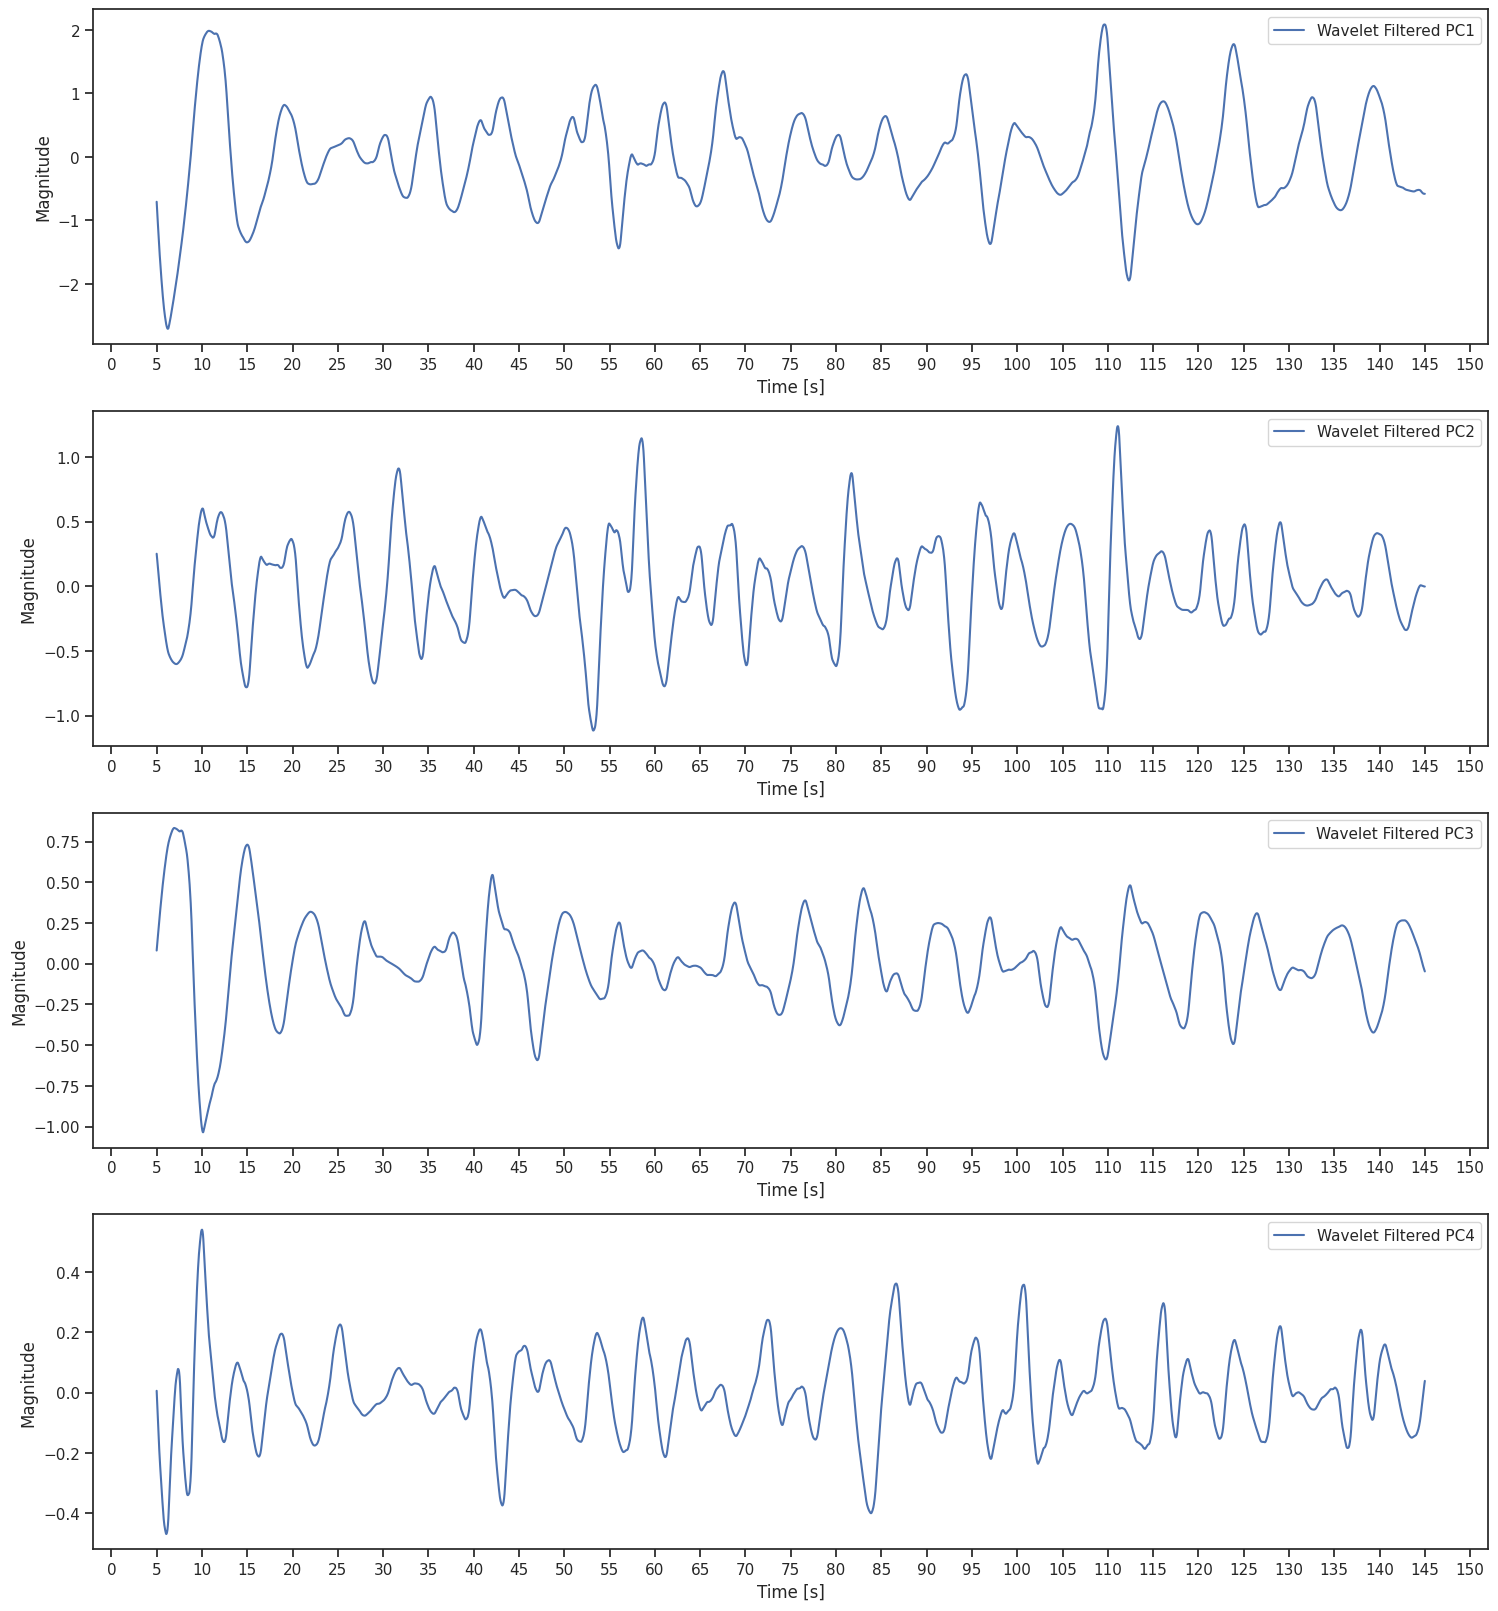

In [16]:
#plot recostructed time signal
fig, axs = plt.subplots(nrows=N_PCA, ncols=1, figsize=(18, N_PCA*5))

for i in range(N_PCA):
    axs[i].plot(data_pca["Abs Time"], filtered_sig[:-1, i], label=("Wavelet Filtered "+PCA_LABELS[i]))
        
    axs[i].set_xlabel("Time [s]")
    axs[i].set_ylabel("Magnitude") 
    axs[i].legend(loc="best")
    axs[i].xaxis.set_major_locator(plt.MultipleLocator(5))
    

We will now quickly repeat a Fourier analysis in order to show that indeed only the desired frequencies are kept after the filter.

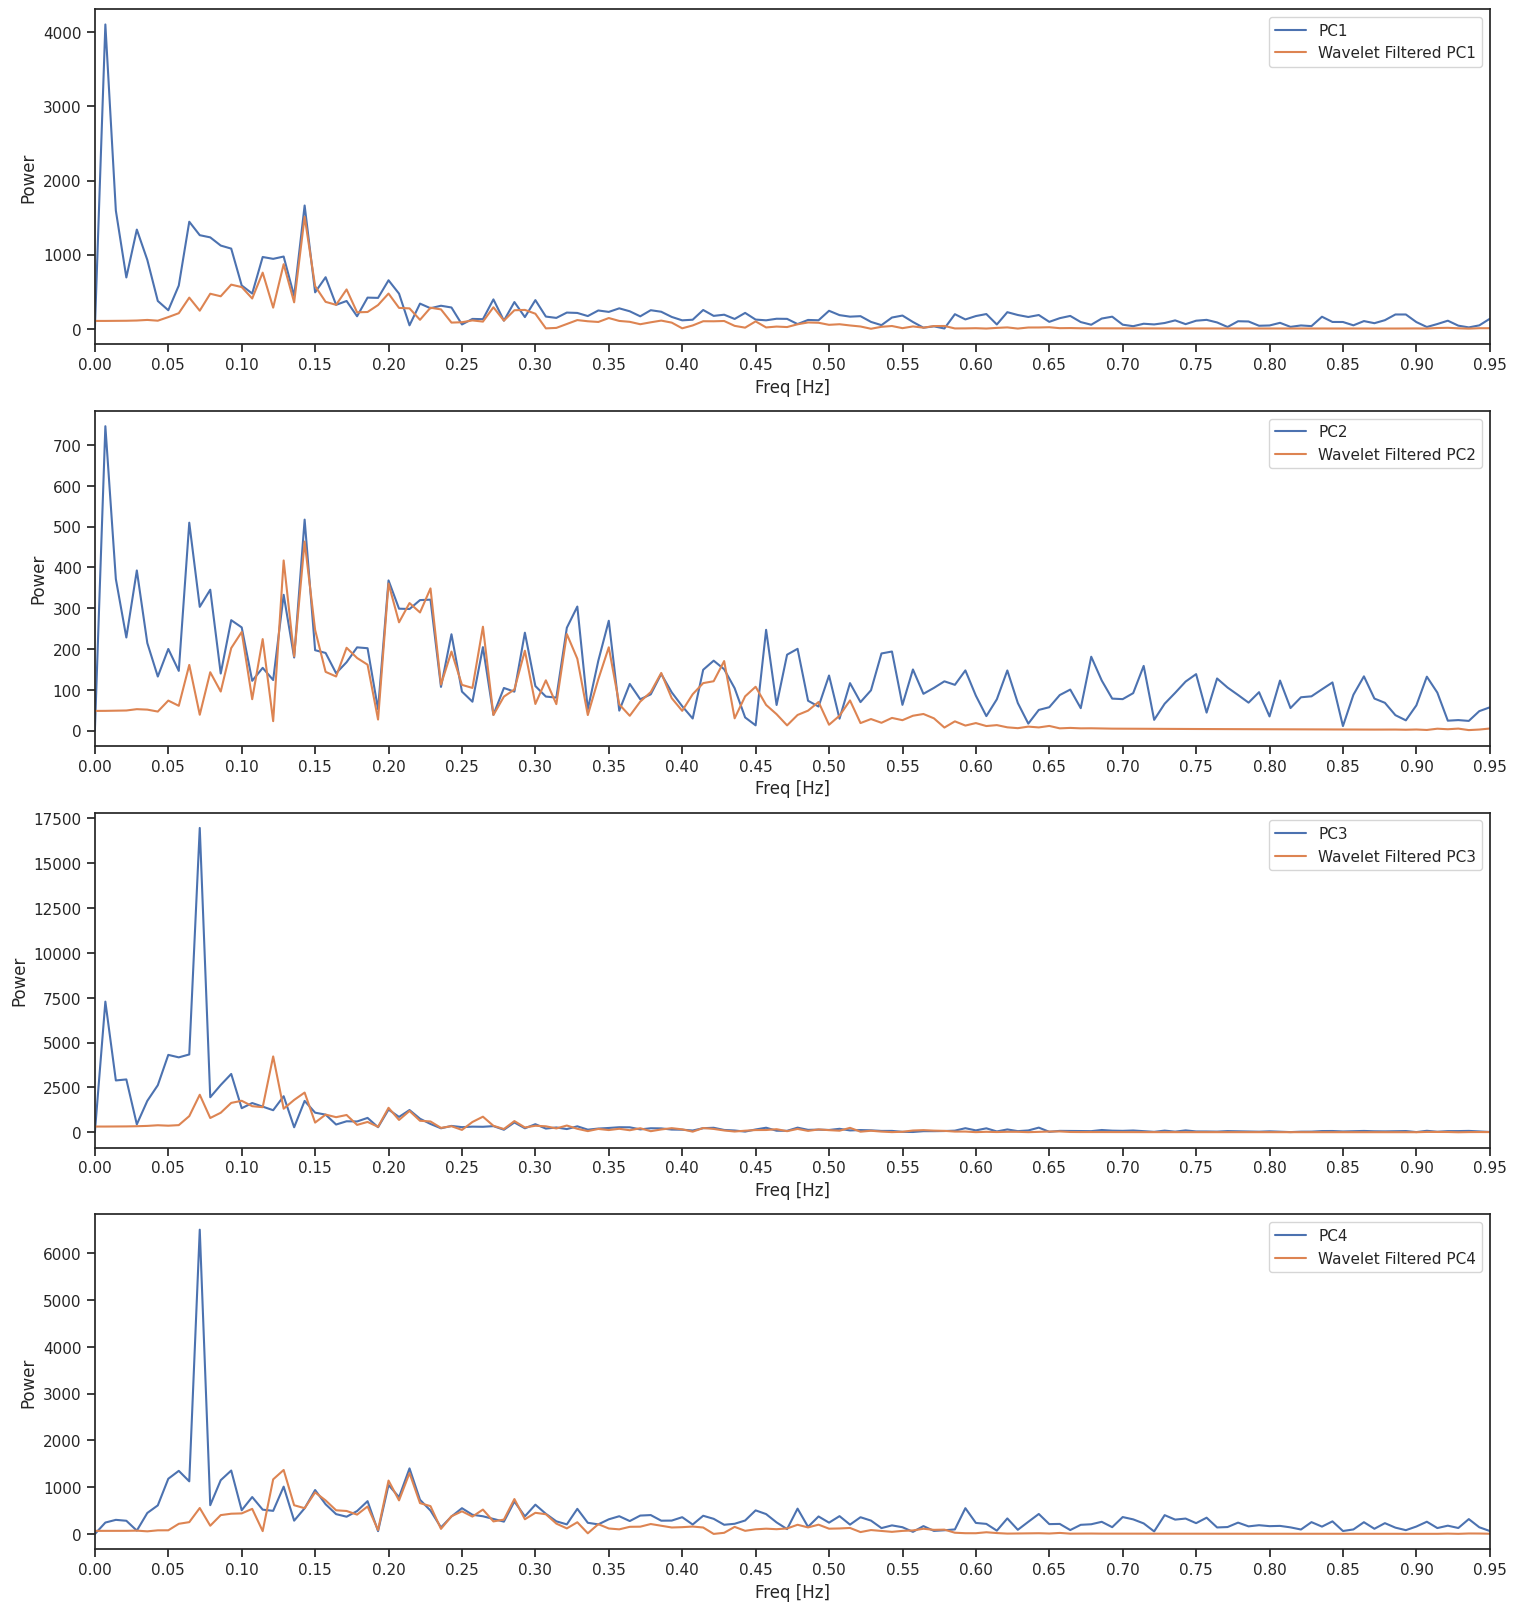

In [17]:
sig_fft_wt = fft.fftshift(fft.fft(filtered_sig[:-1, :], axis=0))
sample_freq = fft.fftshift(fft.fftfreq(len(data_pca), d=1/ACQ_FREQ))

plt.figure(figsize=(18, 5 * N_PCA))
for i in range(N_PCA):
    ax = plt.subplot(N_PCA, 1, i+1)
    plt.plot(sample_freq, np.abs(sig_fft[:, i]), label=PCA_LABELS[i])
    plt.plot(sample_freq, np.abs(sig_fft_wt[:, i]),
             label="Wavelet Filtered " + PCA_LABELS[i])
    ax.set_xlim(0, 0.9)
    plt.xticks(np.arange(0, 1, 0.05))
        
    plt.xlabel("Freq [Hz]")
    plt.ylabel("Power")
    plt.legend(loc="best")
    

# Metrics

### Peak Detection

After having filtered our signals we are ready to extract the **Respiratory Rate (RR)** and the **Respiratory Rate Variability (RRV)** from them. The idea is to spot the peaks of our signals, in order to compute the difference of their corresponding consecutive x-coordinate: this allows us to collect a sample of periods $T_i$ that can be further elaborated to estimate RR and RRV. To do so we start by naively using the find_peaks function of Scipy on each of our filtered PC signals. However, find_peaks, if used without appropriate parameters, returns raw peaks that do not reflect properly the periodicity of the signals, as it will be evident from the example plot below.

In [18]:
filtered_sig=filtered_sig.T

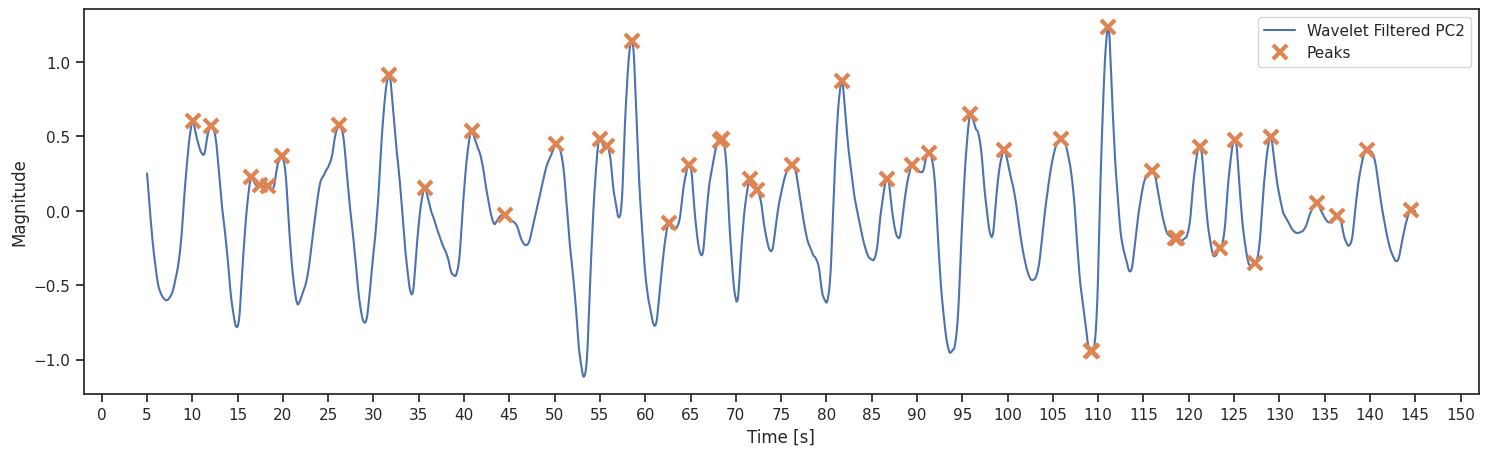

In [19]:
peaks = []
valleys = []
for i in range(len(filtered_sig)):
    temp_signal = filtered_sig[i][:-1]
    temp_peaks, _ = signal.find_peaks(temp_signal)
    temp_valleys, _ = signal.find_peaks(-temp_signal)
    peaks.append(temp_signal[temp_peaks])
    peaks.append(data_std['Abs Time'].values[temp_peaks])
    valleys.append(temp_signal[temp_valleys])
    valleys.append(data_std['Abs Time'].values[temp_valleys])
    
fig, ax = plt.subplots(1, 1, figsize=(18, 5 ))
    
ax.plot(data_std['Abs Time'], filtered_sig[1][:-1], label="Wavelet Filtered "+PCA_LABELS[1])
ax.plot(peaks[1 * 2 + 1], peaks[1 * 2], 'x', label="Peaks", markersize=10, markeredgewidth=3)
ax.set_xlabel("Time [s]")
ax.set_ylabel("Magnitude")
ax.legend(loc="best")
ax.xaxis.set_major_locator(plt.MultipleLocator(5))

'''
fig, ax = plt.subplots(len(filtered_sig), 1, figsize=(18, 5 * N_PCA))
for i in range(len(peaks) // 2):    
    ax[i].plot(data_std['Abs Time'], filtered_sig[i][:-1], label="Wavelet Filtered "+PCA_LABELS[i])
    ax[i].plot(peaks[i * 2 + 1], peaks[i * 2], 'x', label="Peaks", markersize=10, markeredgewidth=3)
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("Magnitude")
    ax[i].legend(loc="best")
''';

### Improving Peak Detection

In order to improve the detection of the peaks we run the code again, paying attention to properly setting the parameters *height* and *distance* of the function find peaks. The former sets an height level that each sample must reach in order to be potentially recognized as a peak, and it has been set equal to the 70% of the mean y-difference between maxima and the following minima. The latter sets a minimum sample distance that needs to occur between subsequent peaks, and has been set equal to the 70% of the mean peak distance. In both cases we have set the 70% of the two quantities so as to preserve the variability of the $T_i$, otherwise small $T_i$ values would have been excessively penalized with respect to larger ones.

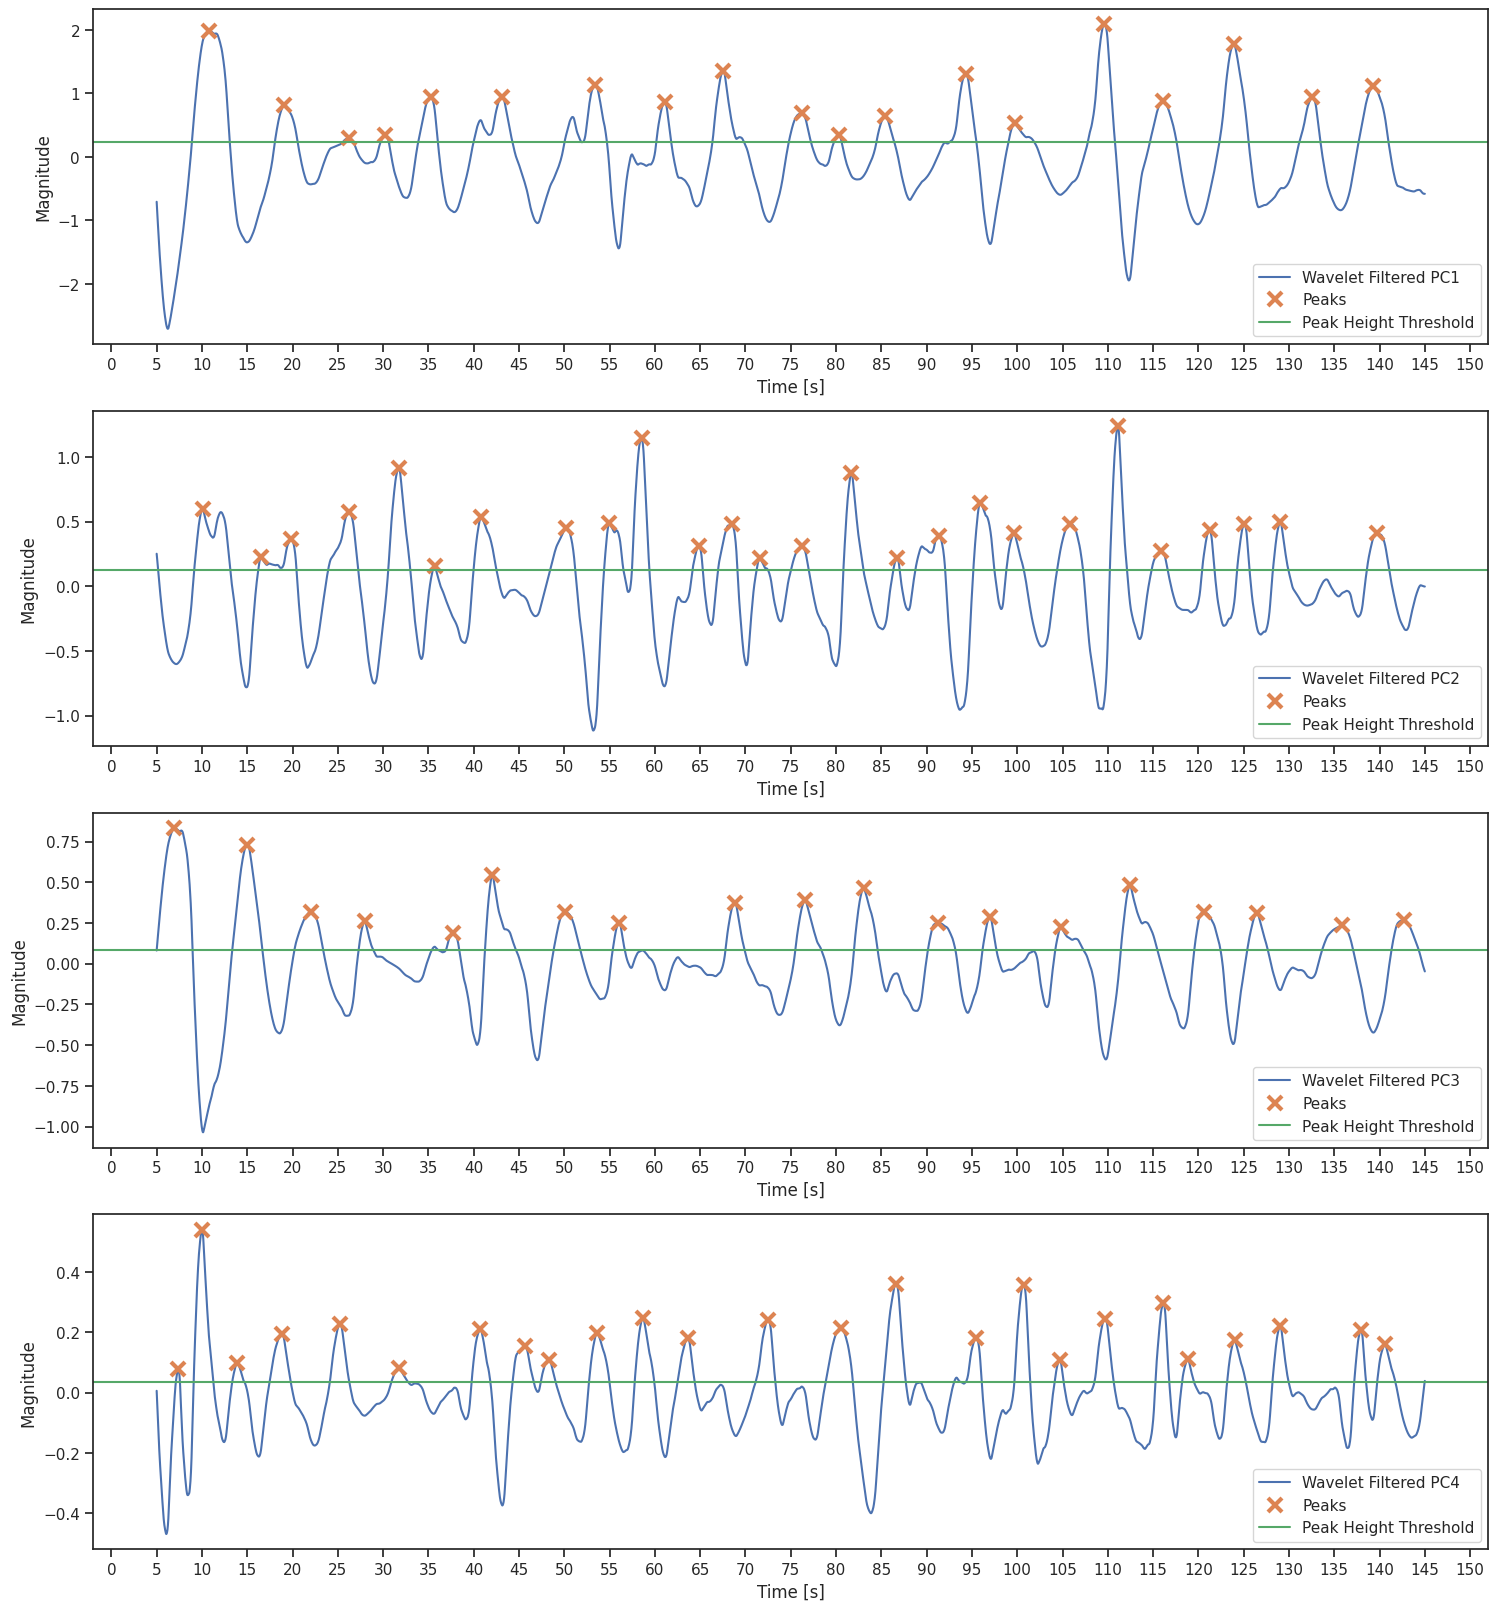

In [20]:
avg_peak_dist = []
for i in range(1, len(peaks), 2):    
    avg_peak_dist.append(len(data_std['Abs Time']) / len(peaks[i]))

sign_amp = []
for i in range(1, len(peaks), 2):
    temp_sign_amp = []    
    for j in range(np.min([len(peaks[i]), len(valleys[i])])):
        temp_peaks = np.array(peaks[i-1])
        temp_valleys = np.array(valleys[i-1])
        temp_sign_amp.append(0.5*np.abs(temp_peaks[j] + temp_valleys[j]))
    sign_amp.append(temp_sign_amp)

avg_sign_amp = np.empty(shape=(len(filtered_sig)))
for i,x  in enumerate(sign_amp):
    avg_sign_amp[i] = np.mean(x)

height_perc = .6
distance_perc = .7
peaks_refined = []
valleys_refined = []
for i in range(len(filtered_sig)):
    temp_signal = filtered_sig[i][:-1]
    temp_peaks, _ = signal.find_peaks(temp_signal, height = height_perc * avg_sign_amp[i], distance = distance_perc * avg_peak_dist[i])
    temp_valleys, _ = signal.find_peaks(-temp_signal)
    peaks_refined.append(temp_signal[temp_peaks])
    peaks_refined.append(data_std['Abs Time'].values[temp_peaks])
    valleys_refined.append(temp_signal[temp_valleys])
    valleys_refined.append(data_std['Abs Time'].values[temp_valleys])

fig, ax = plt.subplots(len(filtered_sig), 1, figsize=(18, 5 * N_PCA))
for i in range(len(peaks_refined) // 2):    
    ax[i].plot(data_std['Abs Time'], filtered_sig[i][:-1], label="Wavelet Filtered "+PCA_LABELS[i])
    ax[i].plot(peaks_refined[i * 2 + 1], peaks_refined[i * 2], 'x', label="Peaks", markersize=10, markeredgewidth=3)
    ax[i].axhline(avg_sign_amp[i] * height_perc, color='g', label="Peak Height Threshold")
    ax[i].legend(loc="best")
    ax[i].xaxis.set_major_locator(plt.MultipleLocator(5))
    ax[i].set_xlabel("Time [s]")
    ax[i].set_ylabel("Magnitude")
    ax[i].legend(loc="lower right")

### Generate Histogram and Estimate Respiratory Rate

After detecting the peaks, the sample of $T_i$ is generated, plotted in an histogram and fitted with a gaussian function in order to estimate the Respiration Rate. 

The set of the T_i contains 85 samples.
Fit parameters (Amplitude, Mean, Sigma): [3.52992288 6.16354863 2.54156667]
Fit parameters errors (Amplitude, Mean, Sigma): [0.63618476 0.5680594  0.63998265]
The estimated Respiratory Period is 6.16 s, corresponding to a Respiratory Rate of 0.16 Hz, i.e. approximately 9.7 breaths per minute.


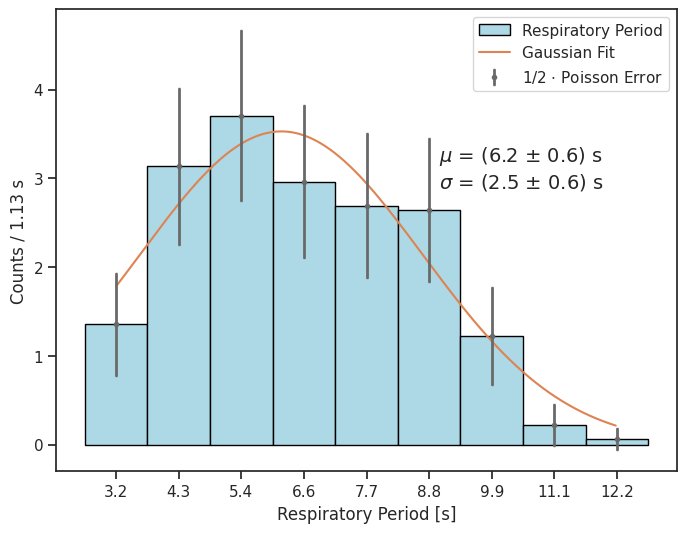

In [21]:
time_dist = []
for i in range(1, len(peaks_refined), 2):
    temp_time_dist = []    
    for j in range(1, len(peaks_refined[i])):
        temp_peaks_time = peaks_refined[i]
        temp_time_dist.append(temp_peaks_time[j]-temp_peaks_time[j-1])
    time_dist.append(temp_time_dist)

weights = [[var_ratios[i] for j in range(len(time_dist[i]))] for i in range(N_PCA)]

time_dist_total = np.concatenate(time_dist)
weights_total = np.concatenate(weights)
print(f'The set of the T_i contains {len(time_dist_total)} samples.')

fig, ax = plt.subplots(figsize=(8,6))
bins = ax.hist(x=time_dist_total, bins=round(np.sqrt(len(time_dist_total))),label="Respiratory Period",
               weights=weights_total, facecolor="lightblue", edgecolor="black")

bin_centers = (bins[1][:-1] + bins[1][1:]) / 2
bin_counts = bins[0]
bin_width = round(bins[1][1]-bins[1][0], 2)

ax.set_xticks(bin_centers)
ax.set_xticklabels(map(lambda x: round(x,1),bin_centers))

def my_gaus(x, A, mu, sigma):
    return A * np.exp(-0.5 * ((x-mu)/sigma) ** 2)

params, params_cov = optimize.curve_fit(my_gaus, bin_centers, bin_counts, p0=[1, np.mean(time_dist_total), np.std(time_dist_total)], absolute_sigma=True, bounds=(0,[100, 100, 100]))
fit_domain = np.sort(np.random.uniform(np.min(bin_centers), np.max(bin_centers), 1000))
ax.plot(fit_domain, my_gaus(fit_domain, *params), label="Gaussian Fit")
ax.set_xlabel("Respiratory Period [s]")
ax.set_ylabel(f"Counts / {bin_width} s")
errors = np.sqrt(bins[0])
ax.errorbar(x=bin_centers, y=bins[0], yerr=errors/2, fmt='.', capsize=1, 
            color='dimgrey', elinewidth=2, label="1/2 $\cdot$ Poisson Error")

ax.text(9.0, 2.9, f'$\mu$ = ({params[1]:.1f} $\pm$ {np.sqrt(np.diag(params_cov)[1]):.1f}) s \n$\sigma$ = ({params[2]:.1f} $\pm$ {np.sqrt(np.diag(params_cov)[2]):.1f}) s', fontsize = 14)

ax.legend()


print('Fit parameters (Amplitude, Mean, Sigma):', params)
print('Fit parameters errors (Amplitude, Mean, Sigma):', np.sqrt(np.diag(params_cov)))
print(f'The estimated Respiratory Period is {params[1]:.2f} s, corresponding to a Respiratory Rate of {1 / params[1]:.2f} Hz, i.e. approximately {60 / params[1]:.1f} breaths per minute.')

For the Respiratory Period estimate we choose the mean parameter returned by the gaussian fit, and we associate to it the respective error.

### Respiratory Rate Variability

Now that we got an estimate of the Respiratory Rate, we need an appropriate quantity that measures its variability. As we have found [here](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8339683/), there are many quantities that are used to estimate Respiratory Rate Variability, according to the specific setup one is working on. A common RRV parameter used in the case of quantitative time series analysis is root mean square of successive differences (RMSSD), defined as 
$$
\text{RMSSD}(\vec{x}) = \sqrt{\frac{1}{N}\sum_{i=2}^{N}|x_i - x_{i-1}|^2}
$$
where the vector $\vec{x}$ represents the set of $T_i$. However, to include in this calculation the information coming from the previous PCA, we decided to perform the weighted mean of the RMSSD of each selected PC, with the weights taken as the variability ratios of each PC. The equation becomes
$$
\text{RMSSD}(\vec{x}) = \frac{1}{\sum_{\text{selected PCs}} w_{PC}} \sum_{\text{selected PCs}} \sqrt{\frac{1}{N_{PC}}\sum_{i=2}^{N_{PC}} |x_i - x_{i-1}|^2} \cdot w_{PC}
$$
Contrary to the previous case, fitting the histogram of the set of successive differences with a gaussian was inconclusive.

The Respiratory Period Variability is 2.67 s.


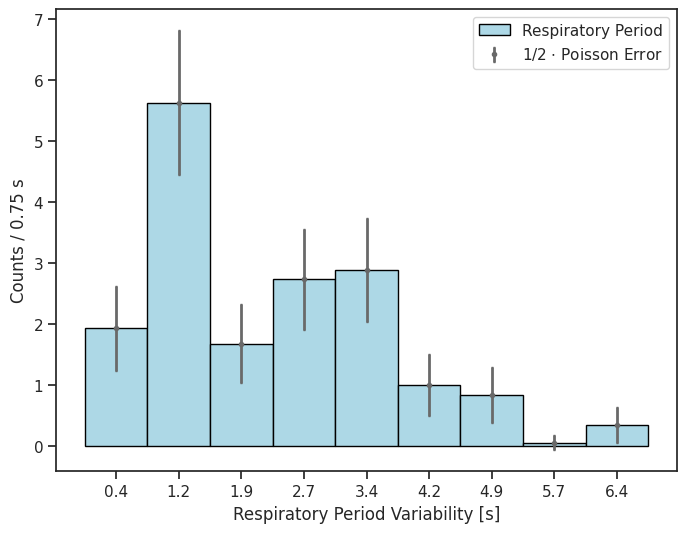

In [22]:
RRVs_sq = np.zeros(shape=len(time_dist))
for i, x in enumerate(time_dist):
    x = np.array(x)
    RRVs_sq[i] = np.sqrt(np.mean(np.diff(x) ** 2))

RRV = np.average(RRVs_sq, weights=var_ratios[:N_PCA])
print(f'The Respiratory Period Variability is {RRV:.2f} s.')

RRVs_set = []
for i, x in enumerate(time_dist):
    x = np.array(x)
    RRVs_set.append(np.abs(np.diff(x)))

weights = [[var_ratios[i] for j in range(len(RRVs_set[i]))] for i in range(N_PCA)]
weights_total = np.concatenate(weights)
RRVs_set = np.concatenate(RRVs_set)


fig, ax = plt.subplots(figsize=(8,6))
bins = ax.hist(x=RRVs_set, bins=round(np.sqrt(len(RRVs_set))),label="Respiratory Period",
               weights=weights_total, facecolor="lightblue", edgecolor="black")

bin_centers = (bins[1][:-1] + bins[1][1:]) / 2
bin_counts = bins[0]
bin_width = round(bins[1][1]-bins[1][0], 2)

ax.set_xticks(bin_centers)
ax.set_xticklabels(map(lambda x: round(x,1),bin_centers))

fit_domain = np.sort(np.random.uniform(np.min(bin_centers), np.max(bin_centers), 1000))
ax.set_xlabel("Respiratory Period Variability [s]")
ax.set_ylabel(f"Counts / {bin_width} s")
errors = np.sqrt(bins[0])
ax.errorbar(x=bin_centers, y=bins[0], yerr=errors/2, fmt='.', capsize=1, 
            color='dimgrey', elinewidth=2, label="1/2 $\cdot$ Poisson Error");
ax.legend();

## Extras

### Alternative Method without Filter

When the filter fails we can devise an alternative method. We first consider only the frequencies range [0.1, 0.25] Hz and select the 3 frequencies with maximum power within it; we the compute their mean and then we get a final estimate with the weighted average of these values between all the considered Principal Components.

In [23]:
mask = (sample_freq > 0.1) & (sample_freq < 0.25)
power_fft = np.abs(sig_fft)
powers = power_fft[mask]
frequencies = sample_freq[mask]

list_freq=[]
power_list=[]

for j in range(N_PCA):
    for i in range(3):
        l=np.argmax(powers[:,j], axis=0)
        list_freq.append(frequencies[l])
        power_list.append(powers[l,j])
        powers[l,j]=0
        
freq_ = np.array(list_freq)
pow_ = np.array(power_list)
pow_ = pow_/(pow_.sum())
freq_ = freq_*pow_


RR = np.array(freq_).sum()

print(f"Respiratory Rate Per Minute is: {RR * 60:.2f}")

Respiratory Rate Per Minute is: 8.72


### Time Signal

Let us plot the features as a function of time individually, zooming in a restricted time window to highlight their trend. 

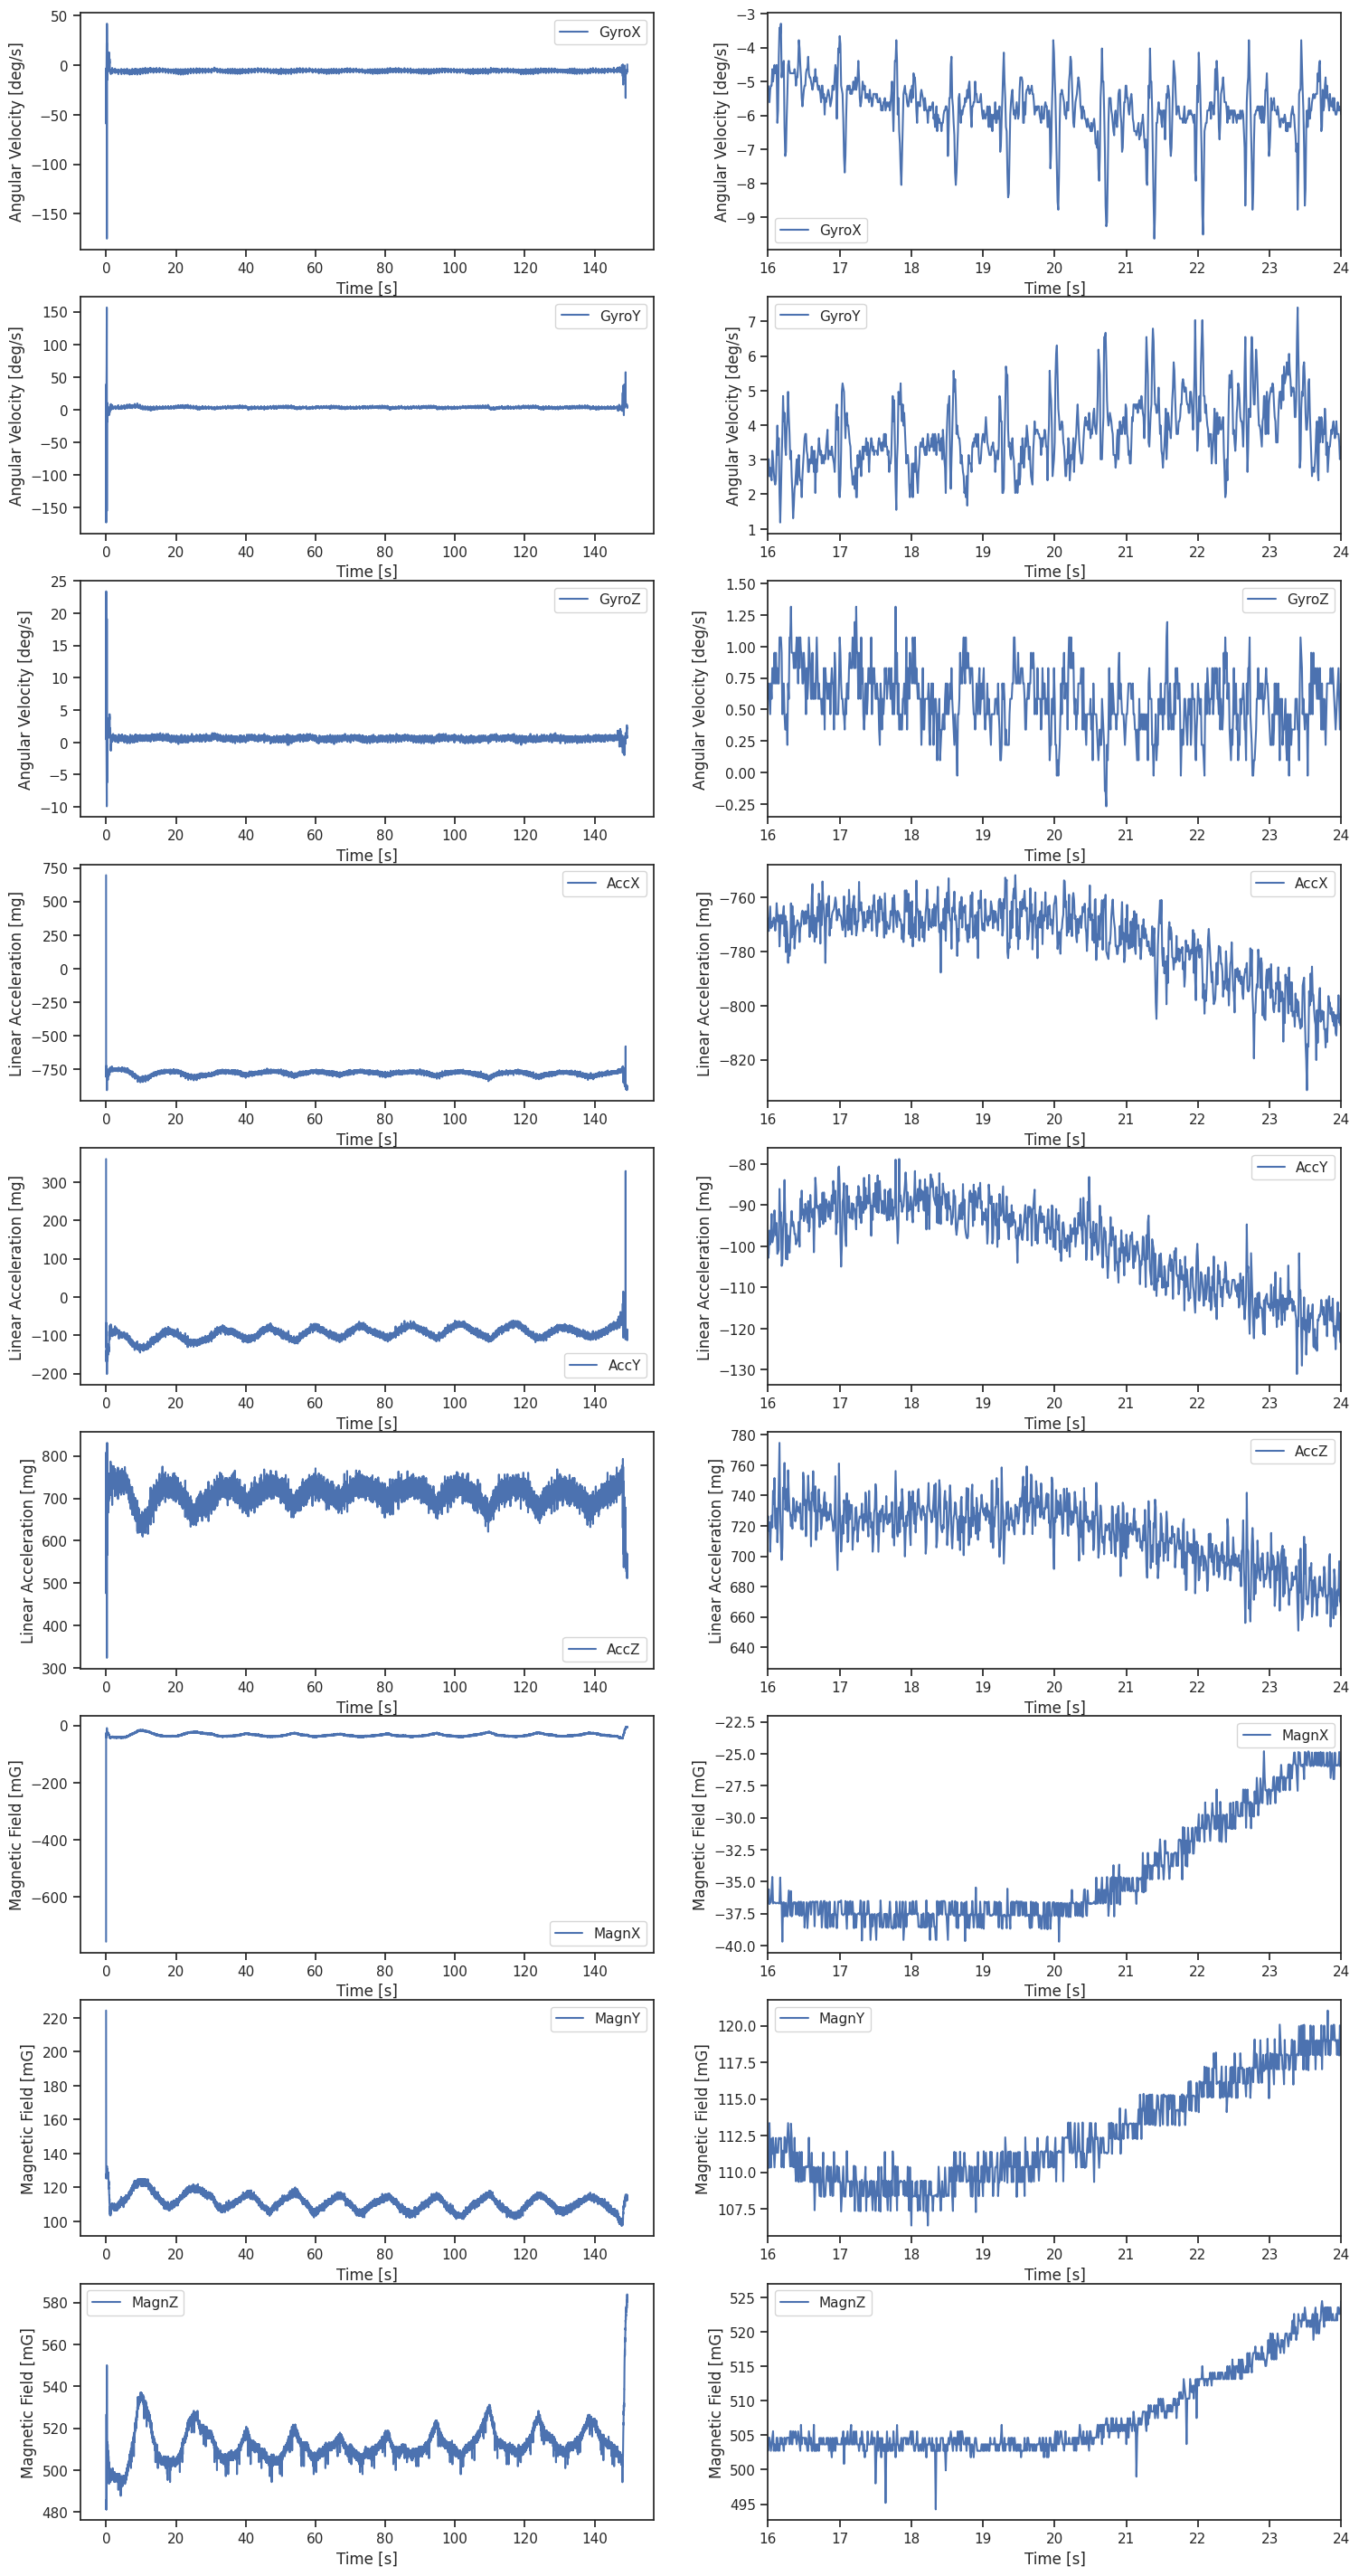

In [24]:
fig, axs = plt.subplots(Nvar, 2, figsize=(18, 4 * Nvar))
for i in range(2):
    for j in range(Nvar):
        if i == 0:
            x_range = raw_data["Abs Time"]
            data_range = raw_data[labels[j]]
        else:
            xmax, xmin = 16, 24
            ixmin, ixmax = (xmax * ACQ_FREQ - 50,  xmin * ACQ_FREQ + 50)
            data_range = raw_data.loc[ixmin:ixmax ,labels[j]]
            x_range = raw_data.loc[ixmin:ixmax, "Abs Time"]
            axs[j][i].set_xlim(xmax, xmin)

        axs[j][i].plot(x_range, data_range, label=labels[j]) #c='b' ?
        axs[j][i].set_xlabel("Time [s]")

        if "Acc" in labels[j]:
            axs[j][i].set_ylabel("Linear Acceleration [mg]")
        elif "Gyro" in labels[j]:
            axs[j][i].set_ylabel("Angular Velocity [deg/s]")
        elif "Magn" in labels[j]:
            axs[j][i].set_ylabel("Magnetic Field [mG]")

        axs[j][i].legend(loc="best")

### Different Types of Filter

We tried different types of filters to find out which one worked best for our purposes.

First, we implemente a simple Butterworth filter in the range [0.1, 0.4] Hz, which has the merit of not having any ripple in the passband (at the expense of rolling slowly towards zero in the stopband).

In [25]:
FREQ_RANGE = (0.1, 0.4)

sos = signal.butter(4, FREQ_RANGE, 'bandpass', fs=ACQ_FREQ, output='sos')
filtered_butter = signal.sosfilt(sos, data_pca[PCA_LABELS], axis=0)

We then try to better this result by constructing a filter pipeline, consisting of a wavelet filter, so as to keep time related information, followed by the previous Butterworth filter. In this case we adopt Daubechies 6 wavelets (db6), as they are smooth and their shape is similar to the shape of heartbeat and respiration pattern buried in SCG. Unfortunately, their maximum decomposition level is smaller than that of sym5 wavelets, so we cannot filter as precisely as above; we thus decompose up to level 8 and keep the respective approximation coefficients to reconstruct the time signal, therefore keeping frequencies in the [0, 0.39] Hz range. This method has the downside of keeping very low frequencies, but this problem is remedied by the following Butterworth filter.

In [26]:
#Filter signal using wavelets
lvl = 8
if file_name != "center_sternum.txt":
    lvl = 7
    
coeffs = pywt.wavedec(data_pca[PCA_LABELS], "db6", level=lvl, axis=0)

#set coefficients related to undesired frequencies to zero 
for i in range(1, lvl + 1):
    coeffs[i] = np.zeros_like(coeffs[i])

#reconstruct time signal 
filtered_wt = pywt.waverec(coeffs, "db6", axis=0)

#Apply Butterworth filter
filtered_wtb = signal.sosfilt(sos, filtered_wt, axis=0)

To check whether all filters act as expected, let us plot as an example the power spectrum of the second principal component. In all three cases, the peaks around 0.2 Hz are kept while low and high frequencies are eliminated, as expected.

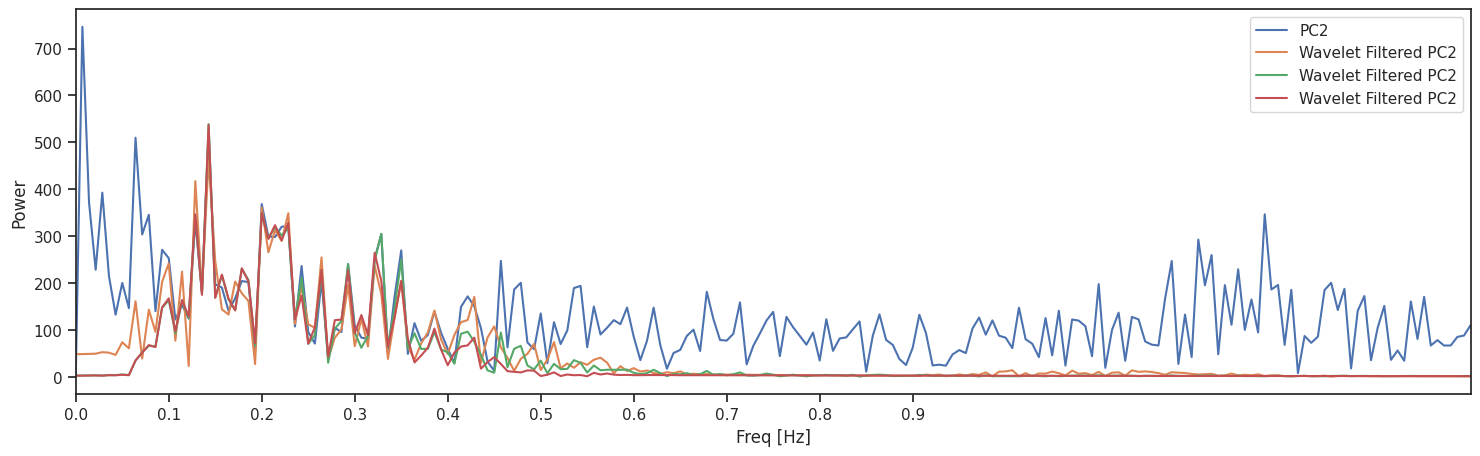

In [27]:
sig_fft_wtb = fft.fftshift(fft.fft(filtered_wtb[:-1, :], axis=0))
sig_fft_butter = fft.fftshift(fft.fft(filtered_butter, axis=0))

plt.figure(figsize=(18, 5))
ax = plt.subplot(1, 1, 1)
plt.plot(sample_freq, np.abs(sig_fft[:, 1]), label=PCA_LABELS[1])
plt.plot(sample_freq, np.abs(sig_fft_wt[:, 1]),
             label="Wavelet Filtered " + PCA_LABELS[1])
plt.plot(sample_freq, np.abs(sig_fft_butter[:, 1]),
             label="Wavelet Filtered " + PCA_LABELS[1])
plt.plot(sample_freq, np.abs(sig_fft_wtb[:, 1]),
             label="Wavelet Filtered " + PCA_LABELS[1])

ax.set_xlim(0, 1.5)
plt.xticks(np.arange(0, 1, 0.1))
        
plt.xlabel("Freq [Hz]")
plt.ylabel("Power")
plt.legend(loc="best");

Now let us plot the reconstructed time signals using the filters just discussed and the one employed in the main analysis, in order to compare the reults; we also plot the original signal (rescaled by factor 2 for purely graphical reasons). 

We observe that the results for the simple Butterworth filter and those of the filter pipeline are almost identical, but both follow less closely the original signal compared to the wavelet sym5 filter. As the analysis is focused on the time related information, we conclude in the end that the latter filter is the best.

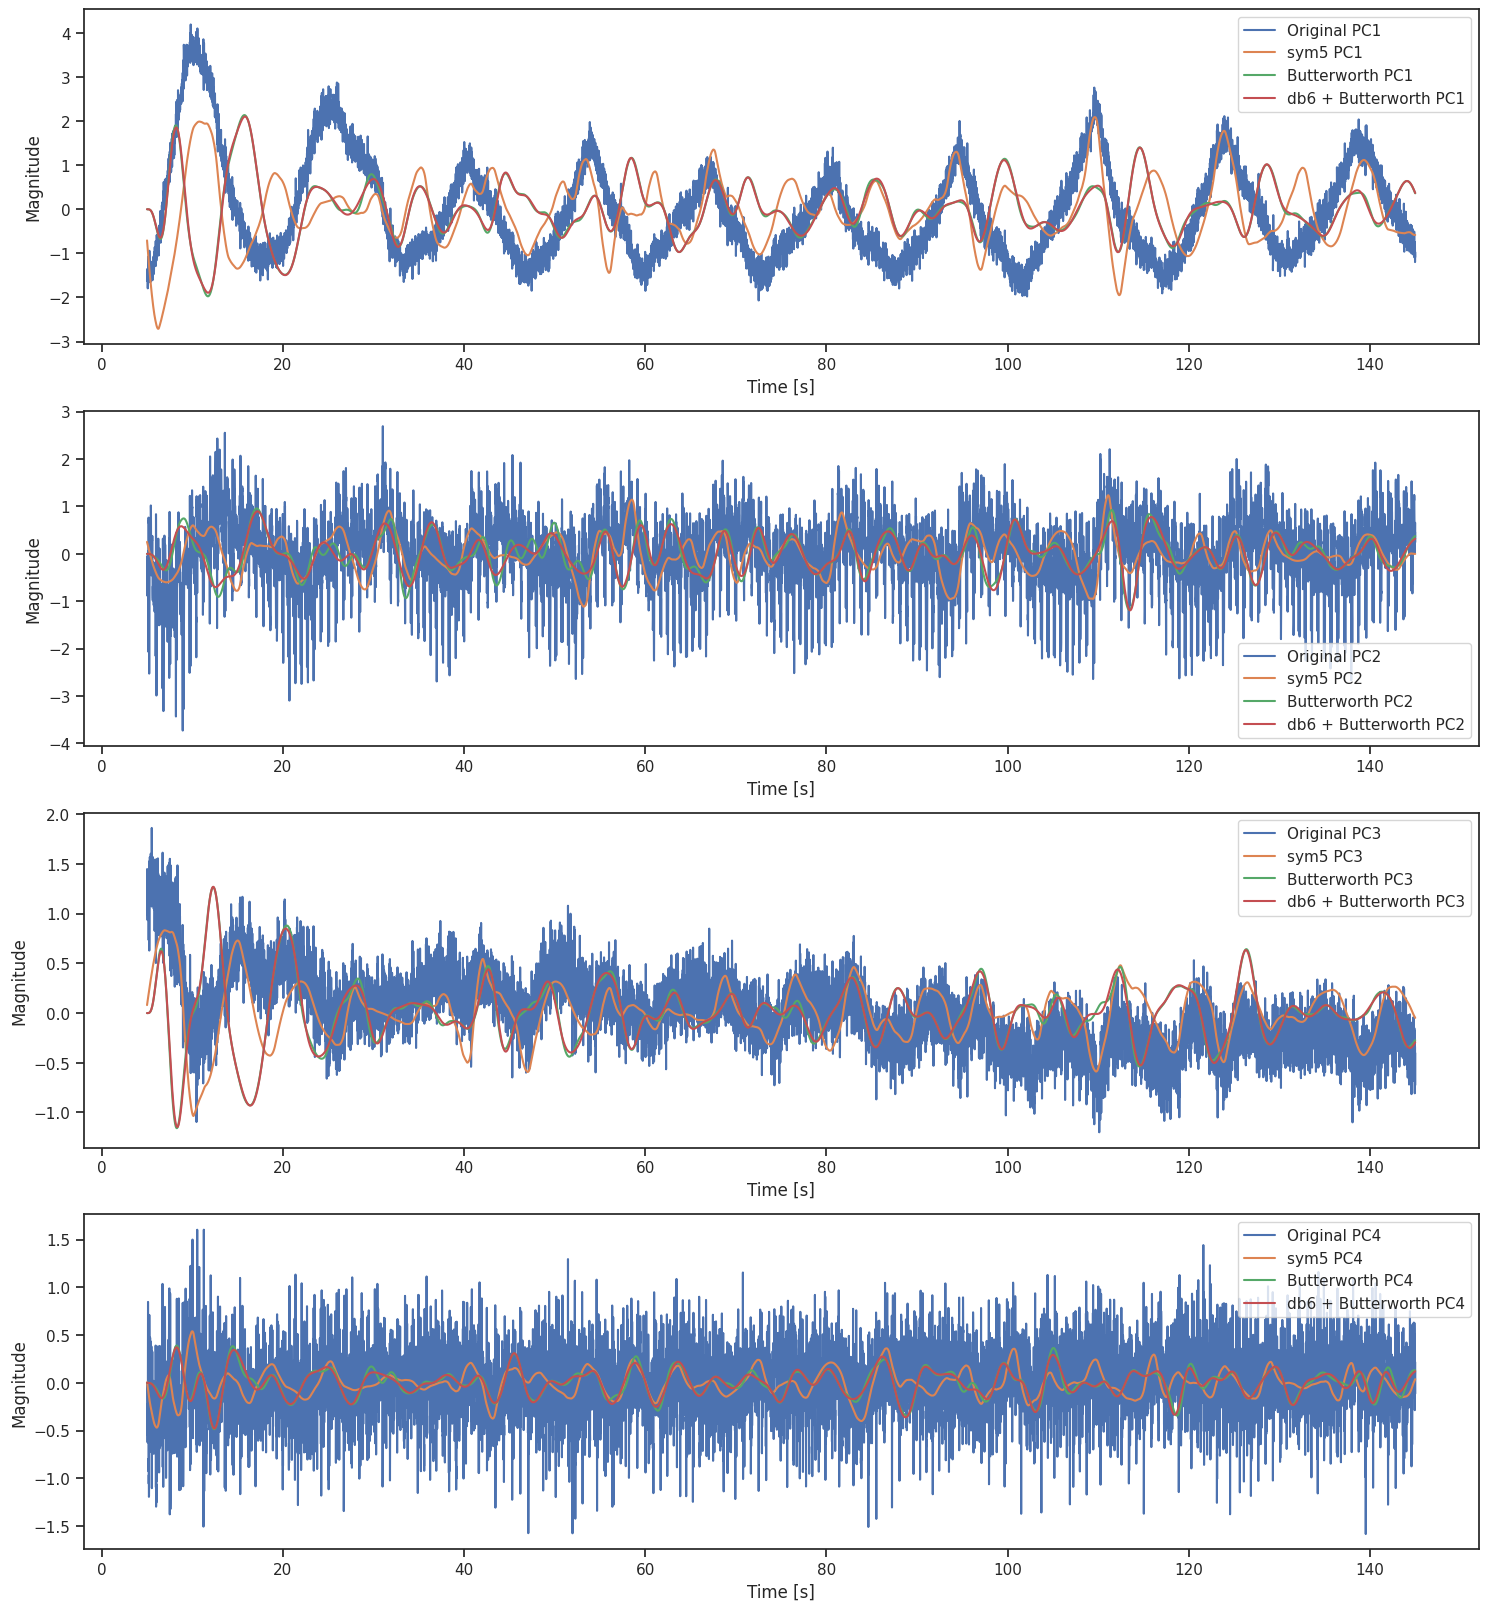

In [28]:
#plot recostructed time signal
fig, axs = plt.subplots(nrows=N_PCA, ncols=1, figsize=(18, N_PCA*5))

for i in range(N_PCA):
    axs[i].plot(data_pca["Abs Time"], data_pca[PCA_LABELS[i]]/2, label=("Original "+PCA_LABELS[i]))
    axs[i].plot(data_pca["Abs Time"], filtered_sig[i,:-1], label=("sym5 "+PCA_LABELS[i]))
    axs[i].plot(data_pca["Abs Time"], filtered_butter[:, i], label=("Butterworth "+PCA_LABELS[i]))
    axs[i].plot(data_pca["Abs Time"], filtered_wtb[:-1, i], label=("db6 + Butterworth "+PCA_LABELS[i]))
        
    axs[i].set_xlabel("Time [s]")
    axs[i].set_ylabel("Magnitude") 
    axs[i].legend(loc="best")